# *Milestone 2*

# Part 0: Initialising

In [ ]:
# Initializing
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

NUM_COLORS = 15
cm = plt.get_cmap('nipy_spectral')

mpl.rcParams.update(params)

import warnings

warnings.filterwarnings("ignore")

To start with, we import three datasets that are available from YouNiverse:

``df_timeseries_en.tsv.gz``  
``df_channels_en.tsv.gz``  
``yt_metadata_helper.feather``

In [ ]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)

df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])

In [ ]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
    ],
)

In [ ]:
df_time_series.head(2)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,202494.555556,0.000000,650.0,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.666667,191591.111111,1046.0,395.777778,6,1,1


In [ ]:
df_channels.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087


In [ ]:
video_metadatas.head(2)

,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id
0,Film & Animation,2016-09-28,1159,8.0,1.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA
1,Film & Animation,2016-09-28,2681,23.0,1.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA


We also import a dataset that is created by us, called `titles_metadata`, which contains the titles and the categories of each video. For Milestone 3, we will generate the same metadata for titles, but include the display ID for matching the titles with videos. For the purpose of Milestone 2 and the initial analysis we continue with the current `titles_metadata`.

In [ ]:
titles_metadata = pd.read_feather(
    "./data/yt_metadata_title_helper.feather")

In [ ]:
titles_metadata.head()

,categories,title
0,Film & Animation,Lego City Police Lego Firetruck Cartoons about...
1,Film & Animation,Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...
2,Film & Animation,Lego City Police Lego Fireman Cartoons about L...
3,Film & Animation,Lego Harry Potter Complete Lego New Movie for ...
4,Film & Animation,Lego City Police 1 HOUR LONG VIDEO for kids Le...


# Part 1: Initial Analysis and Data Visualization

In this section, we analyze the YouNiverse data to determine the potential factors that could lead to success on Youtube. This initial analysis will help us narrow down a subset of the dataset to focus on for our Milestone 3 analysis.

## Question 1: How is the weekly content creation pattern of Youtubers regarding the upload frequency, video lengths, upload time?

### Section 1: Video Upload Frequency

In this section, we mainly consider the weekly video upload frequency. To do that, we first group the `video_metadatas` by upload week for all channels, to have an idea on the upload trends. We do not use `df_time_series` for the purpose of this section, which has ready-to-use weekly information regarding each channel, as it only considers the data from 2015-01-05 to 2019-10-06.

In [ ]:
video_count = (
    video_metadatas.groupby(pd.Grouper(key="upload_date", freq="W")).count().channel_id
)

In [ ]:
for year in range(2005, 2021):
    total_videos_year = video_count[video_count.index.year.isin([year])].sum()
    print("We have {:_} video in {}".format(total_videos_year, year))

We have 316 video in 2005
We have 23_310 video in 2006
We have 136_829 video in 2007
We have 334_681 video in 2008
We have 690_303 video in 2009
We have 1_078_624 video in 2010
We have 1_860_819 video in 2011
We have 2_948_031 video in 2012
We have 4_004_505 video in 2013
We have 5_158_285 video in 2014
We have 6_773_572 video in 2015
We have 9_276_405 video in 2016
We have 12_640_131 video in 2017
We have 15_236_607 video in 2018
We have 12_762_376 video in 2019
We have 0 video in 2020


The above results show that we have to be careful with different timing within each dataframe used. As we will see later on, there are sharp decreases in the data over time, depending on how many videos were crawled.

Text(0.5, 1.0, 'Number of videos uploaded each week')

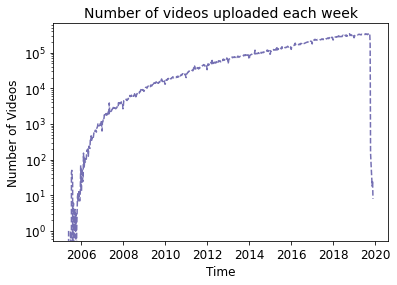

In [ ]:
plt.plot(video_count, color="#7570b3", ls="--", label="\% videos uploaded")
plt.yscale("log")
plt.ylabel("Number of Videos")
plt.xlabel("Time")
plt.title("Number of videos uploaded each week")

From the graph above, we can see that the number of videos being uploaded to YouTube has increased steadily since 2005. We want to have a closer look at the number of videos uploaded by each channel to understand how many videos it takes in order to be successfull. For this preliminary analysis, we only consider the number of videos uploaded by each channel per year.

In [ ]:
# The following graph shows how many videos each channel uploads to YouTube per year.
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
vd_cnt_by_id_yr = (
    video_metadatas.groupby(["channel_id", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_yr.columns.name = None
vd_cnt_by_id_yr_summary = vd_cnt_by_id_yr.describe()

Text(0.5, 1.0, 'The 2nd and 3rd quartiles of yearly video upload frequency')

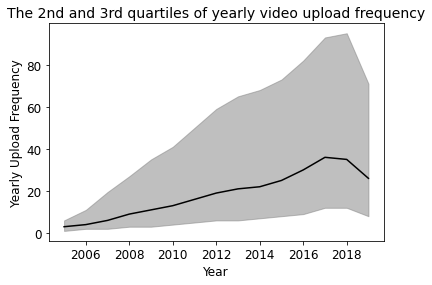

In [ ]:
plt.fill_between(
    x=list(vd_cnt_by_id_yr_summary.columns.values),
    y1=list(vd_cnt_by_id_yr_summary.loc["25%", :]),
    y2=list(vd_cnt_by_id_yr_summary.loc["75%", :]),
    alpha=0.5,
    color="gray",
)
plt.plot(vd_cnt_by_id_yr_summary.loc["50%", :], color="black")
plt.xlabel("Year")
plt.ylabel("Yearly Upload Frequency")
plt.title("The 2nd and 3rd quartiles of yearly video upload frequency")
# here we choose quartiles, since the mean would be significantly affected by extremely high yearly upload rates

This graph demonstrates that English-language YouTubers upload more videos annually over time. Additionally, since the study period began, there has been a considerable increase in the variation in upload frequency between channels, indicating an increase in the large heterogeneity of upload frequency. 

### Section 2: Video Lengths

Firstly, we will take a look at the basic statistics of video lengths using `video_metadatas` . To make it easier to understand, we first convert the duration into minutes for the subsequent analysis.

In [ ]:
# divide the video duration by 60 to convert duration to minutes
video_metadatas["duration_min"] = video_metadatas["duration"] / 60
video_metadatas.duration_min.describe()

count    7.292479e+07
mean     1.262794e+01
std      3.033518e+01
min      1.666667e-02
25%      2.233333e+00
50%      4.733333e+00
75%      1.163333e+01
max      6.002617e+03
Name: duration_min, dtype: float64

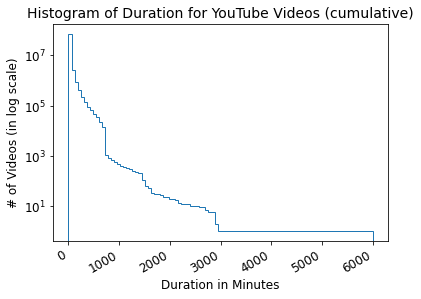

In [ ]:
duration_min_cumul = plt.hist(
    video_metadatas.duration_min, bins=100, log=True, cumulative=-1, histtype="step"
)
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration in Minutes")
plt.xticks(rotation=30, ha="right")
plt.show()

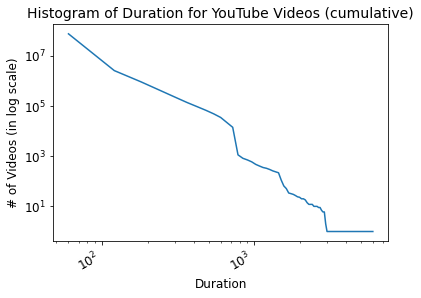

In [ ]:
plt.loglog(duration_min_cumul[1][1:], duration_min_cumul[0])
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration")
plt.xticks(rotation=30, ha="right")
plt.show()

From the basic statistics and the histogram, we can observe a significant difference between the mean (12.63 minutes) and the median (4.73 minutes). Furthermore, the maximum duration (100 hours) is much higher compared to both, the median and the mean. The distribution of the duration resembles that of a heavy tailed distribution. This observation suggests that there are extremely long videos in the dataset that would increase the mean significantly. Therefore, a visualization with quartiles serves as a less distorted representation of the dataset as it does not consider outliers.

Therefore, we have a look at the quartiles of duration of videos in the dataset to have a better idea about the distribution: 

Text(0.5, 1.0, 'Duration of Videos in Minutes')

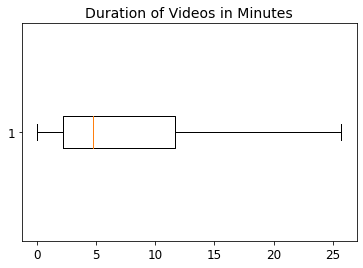

In [ ]:
plt.boxplot(video_metadatas["duration_min"], showfliers=False, vert=False)
plt.title("Duration of Videos in Minutes")

Here, we see that throughout the study period, most of the videos are between zero and 25 minutes long. To investigate whether the variation of video length is also varying with time, we take a look at the evolution over time.

In [ ]:
vd_duration_by_id_yr = (
    video_metadatas.groupby(["channel_id", "yearNumber"])["duration_min"]
    .mean()
    .unstack()
    .reset_index()
)
vd_duration_by_id_yr.columns.name = None
vd_duration_by_id_yr_summary = vd_duration_by_id_yr.describe()

Text(0.5, 1.0, 'The 2nd and 3rd quartiles of average yearly video duration')

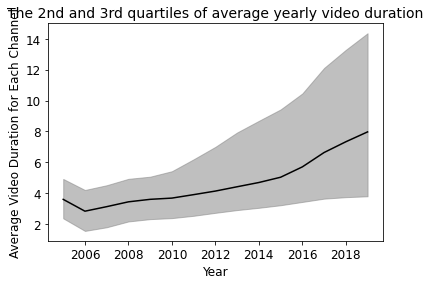

In [ ]:
plt.fill_between(
    x=list(vd_duration_by_id_yr_summary.columns.values),
    y1=list(vd_duration_by_id_yr_summary.loc["25%", :]),
    y2=list(vd_duration_by_id_yr_summary.loc["75%", :]),
    alpha=0.5,
    color="gray",
)
plt.plot(vd_duration_by_id_yr_summary.loc["50%", :], color="black")
plt.xlabel("Year")
plt.ylabel("Average Video Duration for Each Channel")
plt.title("The 2nd and 3rd quartiles of average yearly video duration")
# here we choose quartiles, since the mean would be significantly affected by extremely high yearly upload rates

From this graph, it is obvious that the variance of mean video duration for each channel is increasing with time, and the median itself is also increasing with time. This means that compared to the beginning of the study period, channels increased the video duration, and there are more channels with vastly different video duration towards the end of the study period.

### Section 3: Upload Time
In this section, we want to investigate at what points during the week YouTubers upload their videos.

In [ ]:
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday
vd_cnt_by_id_wk = (
    video_metadatas.groupby(["channel_id", "weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_wk.columns.name = None
vd_cnt_by_id_wk["mean_upload"] = vd_cnt_by_id_wk.iloc[:, 2:].mean(axis=1, skipna=True)

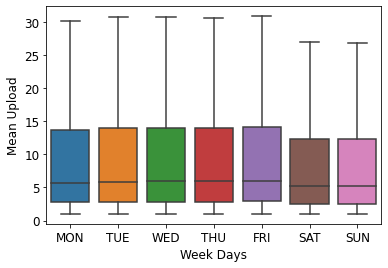

In [ ]:
labels = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
ax = sns.boxplot(
    x="weekNumber", y="mean_upload", data=vd_cnt_by_id_wk, showfliers=False
).set(xlabel="Week Days", ylabel="Mean Upload", xticklabels=labels)

This boxplot shows that the variation between upload rate during weekdays are not significantly different. However, during the weekend, it seems that mean upload rate is less than during the week. In the next step, we once again visualize it by counting the total number of videos uploaded each day of the week, regardless of the channel ID:

In [ ]:
vd_cnt_by_wk = (
    video_metadatas.groupby(["weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_wk.columns.name = None

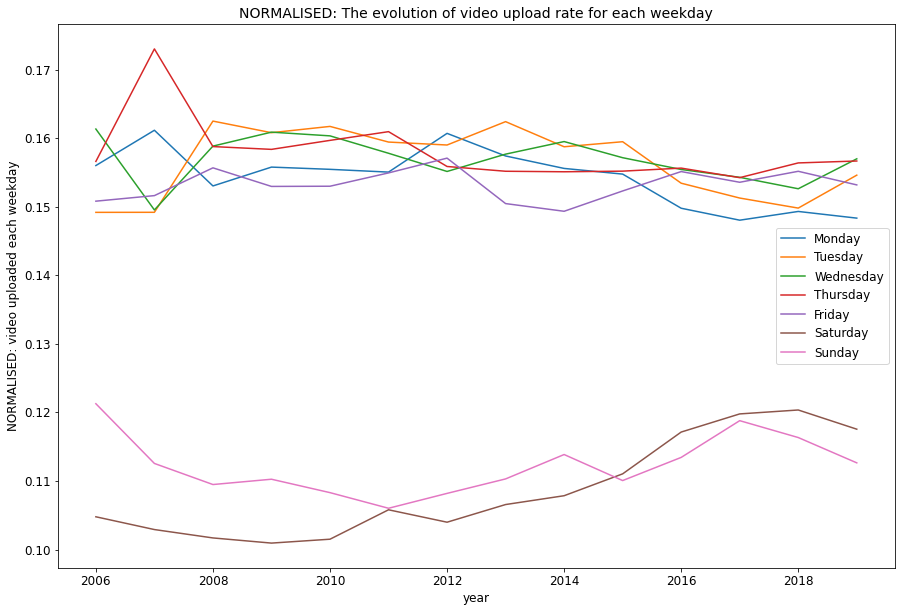

In [ ]:
vd_cnt_by_wk_norm = vd_cnt_by_wk.iloc[:, 2:] / vd_cnt_by_wk.iloc[:, 2:].sum(skipna=True)
plt.rcParams["figure.figsize"] = (15, 10)
plt.plot(vd_cnt_by_wk_norm.T)
plt.legend(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
plt.xlabel("year")
plt.ylabel("NORMALISED: video uploaded each weekday")
plt.title("NORMALISED: The evolution of video upload rate for each weekday")
plt.show()

This graph suggests that the number of videos uploaded from Monday to Friday is not significantly different from each other throughout the study period. Generally speaking, YouTubers upload more videos during weekdays than during weekends. However, we can also observe an increasing number of videos uploaded on Saturdays in more recent years.

## Question 2: How are the subscription patterns for reaching key numbers of subscribers, aka, 1k, 10k, 100k, 1M?

In this section, we investigate the time frame for YouTubers to reach key milestones in their channel success - number of subscriptions.

In [ ]:
def get_df_channel_ascension(start_subs, end_subs):
    """finds the channels in the time series that have less than the start_subs and more than end_subs.
    It means that it begins with less than start_subs and have now at least end_subs

    Args:
        start_subs (float): low_threshold
        end_subs (float): high_threshold

    Returns:
        dataframe containing all the channels with evolution from starts_subs to end_subs
    """
    under_start_subs = df_time_series[df_time_series["subs"] < start_subs]
    more_end_subs = df_time_series[df_time_series["subs"] > end_subs]
    channel_start_to_end = df_time_series[
        df_time_series.channel.isin(under_start_subs.channel)
        & df_time_series.channel.isin(more_end_subs.channel)
    ]
    return channel_start_to_end

In [ ]:
def get_mean_time_to_reach_X_subs(df, lower_bound, upper_bound):
    time_to_reach_X_subs = df.groupby("channel").apply(
        lambda group: pd.Series(
            {
                "from_zero_to_hero_duration": group[group.subs > upper_bound][
                    "datetime"
                ].iloc[0]
                - group[group.subs < lower_bound]["datetime"].iloc[-1]
            }
        )
    )
    return time_to_reach_X_subs

In [ ]:
channel_10K_to_1M = get_df_channel_ascension(10_000, 1_000_000)
print(
    "We have {} channels that begins with at most 10K subs and reach at least 1M".format(
        channel_10K_to_1M.channel.nunique()
    )
)

We have 1252 channels that begins with at most 10K subs and reach at least 1M


In the next step be provide an example of a channel to implement the function defined above:

There are 113 weeks for this channel
We should have approximately the same value : 
791 and 784 days 00:00:00


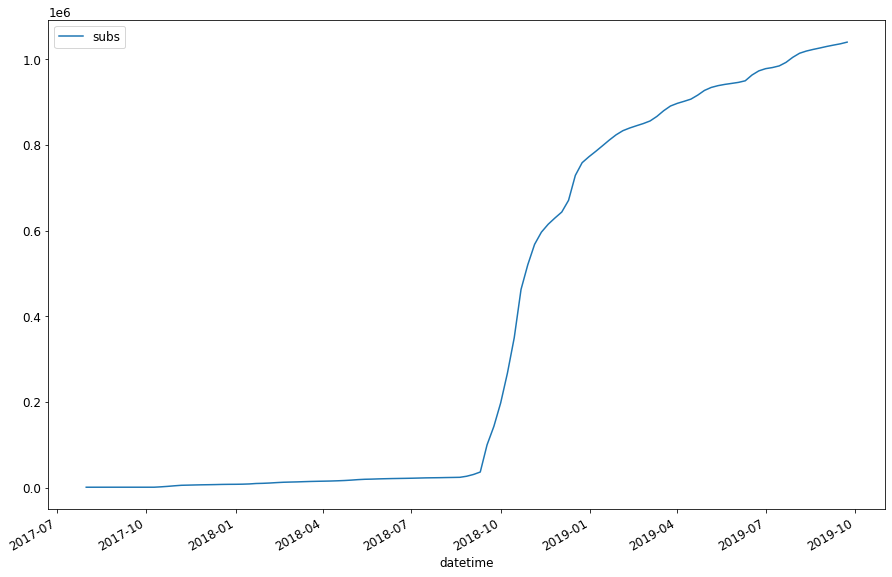

In [ ]:
first_channel = channel_10K_to_1M.iloc[0]
test = channel_10K_to_1M[channel_10K_to_1M["channel"] == first_channel.channel]
# test = test[(test['datetime'] > np.datetime64('2018-07-20')) & (test['datetime'] < np.datetime64('2019-01-20'))]
test.plot(x="datetime", y="subs")
print("There are {} weeks for this channel".format(test.shape[0]))

# just check that the first dimension of the test df (it gives the nb of weeks) multiplied
# by 7 (it gives the total nb of days) is equal to the last date - first date. If yes, then we have a continuous
# chronology
print(
    "We should have approximately the same value : \n{} and {}".format(
        7 * test.shape[0], test.iloc[-1].datetime - test.iloc[0].datetime
    )
)

In [ ]:
# get the time it takes to go from less than 10K to 1M
time_to_reach_1M = get_mean_time_to_reach_X_subs(channel_10K_to_1M, 10_000, 1_000_000)
time_to_reach_1M.head()

,from_zero_to_hero_duration
channel,
UC-3fLOkTRb7-tepOqxsDdDg,97 days 23:00:00
UC-5Yj4HIiruwkzFuLflxL_w,574 days 01:00:00
UC-CSyyi47VX1lD9zyeABW3w,769 days 23:00:00
UC-HOjVdbw0TG6h44rH4Sirw,413 days 00:00:00
UC-LUjxkSJCxAMrZ4S0T3Drg,686 days 01:00:00


In [ ]:
print(
    "On average YTbers take {} days to reach 1M of subscribers".format(
        time_to_reach_1M["from_zero_to_hero_duration"].mean().days
    )
)

In average YTbers take 511 days to reach 1M of subscribers


We will then bootstrap this result for Milestone 3 to see the time it takes to reach 1M subscribers and its respective confidence interval.

In [ ]:
data = time_to_reach_1M["from_zero_to_hero_duration"].apply(
    lambda delta_time: delta_time.days
)

In [ ]:
rng = np.random.default_rng()
conf_interval_reach_1M = bootstrap(
    (data,),
    np.mean,
    confidence_level=0.95,
    random_state=rng,
).confidence_interval
conf_interval_reach_1M

print(
    "The 95% interval of confidence, the time taken to reach 1M (from 10K) is [{}, {}]".format(
        conf_interval_reach_1M.low, conf_interval_reach_1M.high
    )
)

The 95% interval of confidence, the time taken to reach 1M (from 10K) is [498.60452947983714, 523.3986376851142]


## Question 3: Which categories are more popular during the study period? Which types of videos receive more positive feedback?

In this question, we use `video_metadatas` to determine which categories are more popular and have a high amount of views. This step helps in narrowing down our categories of interest to three categories that we want to investigate further for Milestone 3.

### Section 1: Number of Views

In [ ]:
#  make a copy of the video_metadatas
videos_with_cat = video_metadatas[:]
videos_with_cat["categories"] = videos_with_cat["categories"].apply(
    lambda x: x.replace(" & ", "_")
)

# delete the rows with empty categories
videos_with_cat.categories.replace("", np.nan, inplace=True)
videos_with_cat.dropna(subset=["categories"], inplace=True)

In [ ]:
# Average view counts for videos from each category across time
mean_views_groupby = (
    videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).mean()
)
mean_views_groupby = mean_views_groupby.view_count.unstack().reset_index()
mean_views_groupby.columns.name = None
mean_views = mean_views_groupby.sort_values(
    by=2019, ascending=False, ignore_index=True
)

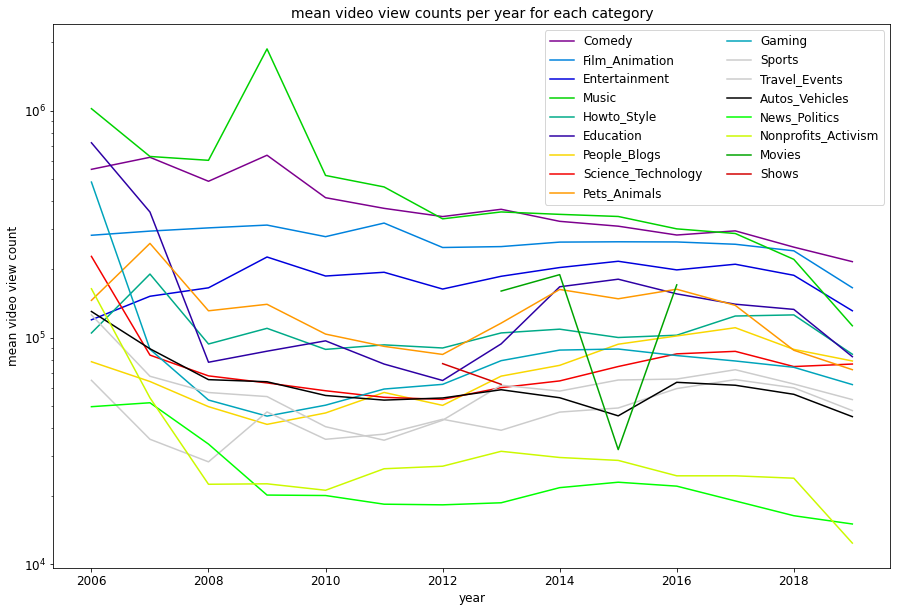

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(mean_views.shape[0]):
    plt.plot(
        mean_views.loc[
            i,
        ][2:],
        label=mean_views.loc[i,][
            0:1
        ][0],
        color=cm(1.*mean_views_groupby[mean_views_groupby.categories==mean_views.loc[i,][0:1][0]].index/NUM_COLORS)
    )
plt.semilogy()    
plt.legend(loc="upper right", ncol=2)
plt.xlabel("year")
plt.ylabel("mean video view count")
plt.title("mean video view counts per year for each category")
plt.show()

The results of the data above is obtained by averaging the view counts of all videos in the same category by year. It shows that on average, Music and Comedy are the two top categories for view counts from 2005 to 2017. From 2018 to 2019, Film & Animation replaces Music on the top two spots. However, all top four categories are showing a decrease in their mean video view counts. However, there is not a genre of videos that shows obvious growth in mean video view counts over the study period, while most of the categories seem to stay more or less the same level, non-profit and news & politics categories seem to have obvious drop in their mean video view counts.

Now let's investigate how popular the videos from each category are, and how the trends change over time. For this purpose, we shift to the total video view counts, instead of the mean ones.

In [ ]:
# determine how many videos are uploaded to YouTube by each channel by year
video_count_by_year = (
    videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).sum()
)
video_view_count_by_year_groupby = video_count_by_year.view_count.unstack().reset_index()
video_view_count_by_year_groupby.columns.name = None
video_view_count_by_year = video_view_count_by_year_groupby.sort_values(
    by=2019, ascending=False, ignore_index=True
)
# NOTE THAT CATEGORIES::MOVIES AND SHOWS HAVE VERY FEW DATA!

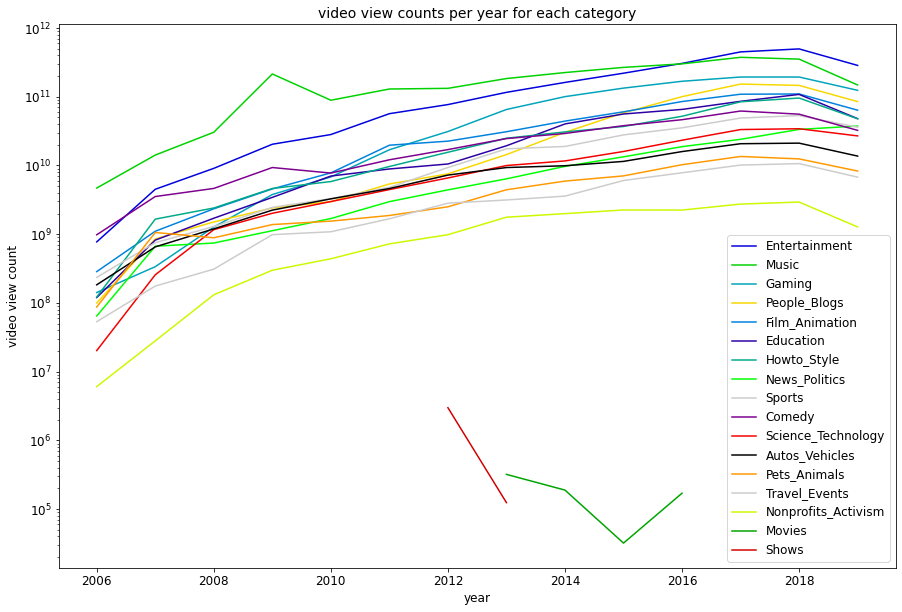

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
        color=cm(1.*video_view_count_by_year_groupby[video_view_count_by_year_groupby.categories==video_view_count_by_year.loc[i,][0:1][0]].index/NUM_COLORS)
    )
plt.semilogy()    
plt.legend(loc="lower right")
plt.xlabel("year")
plt.ylabel("video view count")
plt.title("video view counts per year for each category")
plt.show()

From the previous plot, we see that by 2019, the top four categories with highest mean view counts are Comedy, Film & Animation, Music, Gaming, while People & Blogs places as the 7th category. However, we can observe that the total view counts for People & Blogs enters the top four categories. This means that although that videos under People & Blogs have on average less views per video, there are probably a lot of videos under People & Blogs out there. To verify this observation we create another plot.


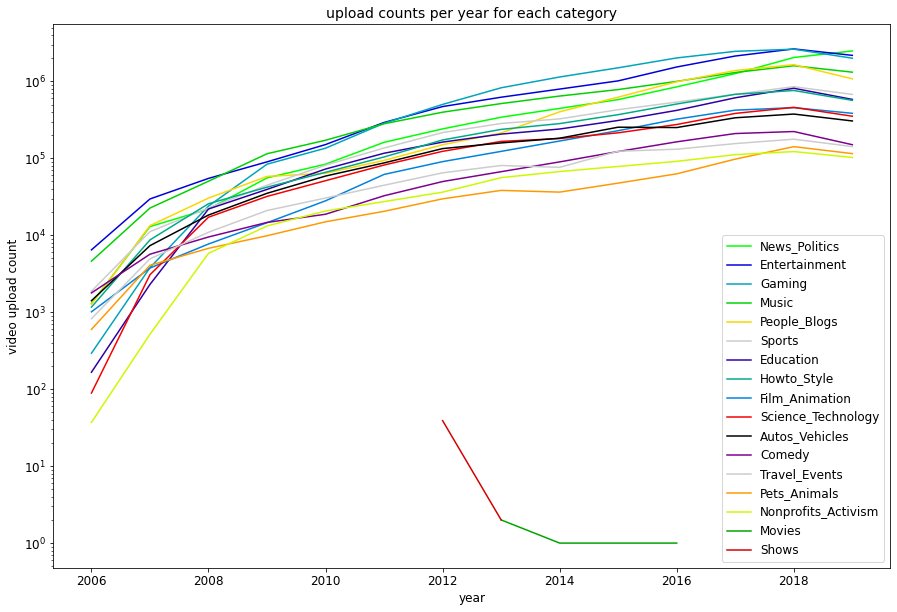

In [ ]:
# determine how many videos are uploaded to YouTube by each channel by year
upload_count_by_year_groupby = (
    videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).count()
)
upload_count_by_year_groupby = upload_count_by_year_groupby.view_count.unstack().reset_index()
upload_count_by_year_groupby.columns.name = None
upload_count_by_year = upload_count_by_year_groupby.sort_values(
    by=2019, ascending=False, ignore_index=True
)

plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(upload_count_by_year.shape[0]):
    plt.plot(
        upload_count_by_year.loc[
            i,
        ][2:],
        label=upload_count_by_year.loc[i,][
            0:1
        ][0],
        color=cm(1.*upload_count_by_year_groupby[upload_count_by_year_groupby.categories==upload_count_by_year.loc[i,][0:1][0]].index/NUM_COLORS)
    )
plt.semilogy()    
plt.legend(loc="lower right")
plt.xlabel("year")
plt.ylabel("video upload count")
plt.title("upload counts per year for each category")
plt.show()

Here we can observe that indeed there are more videos under the People & Blogs category, compared to the other two categories with high mean view counts, Comedy and Film & Animation. This result suggests that the high total view counts can beat Comedy and Film & Animation probably because of the high volume of videos uploaded.

Lastly, we want to find out how the video views are distributed between different categories for each year. To do that, we divide the total video counts per category per year by total video counts per year.

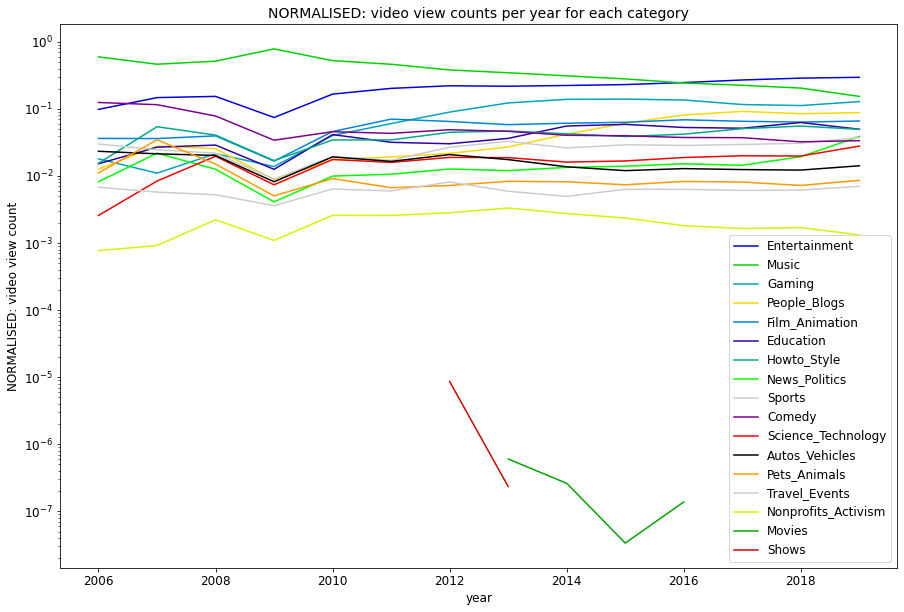

In [ ]:
# NORMALISATION:
## 1. view count - normalise wrt. total video views per year, to see which categories is viewed more every year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:]
        / video_view_count_by_year.sum(axis=0)[2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
        color=cm(1.*video_view_count_by_year_groupby[video_view_count_by_year_groupby.categories==video_view_count_by_year.loc[i,][0:1][0]].index/NUM_COLORS)
    )
plt.semilogy()  
plt.legend(loc="lower right")
plt.xlabel("year")
plt.ylabel("NORMALISED: video view count")
plt.title("NORMALISED: video view counts per year for each category")
plt.show()
# view on music videos decreases, whereas on entertainment and gaming increases

This result indicates that the share of video counts across different categories are quite stable across the study period. However, it is also obvious that the view counts for Music is decreasing, and that for Entertainment, Gaming and People & Blogs are somewhat increasing.

One factor we haven't considered so far is the effect of number of subscribers on view counts. Here, we divide the weekly view counts over subscribers from `df_time_series`, and investigate whether the number of subscribers and view counts are correlated in a way.

In [ ]:
# use the time series dataframe to implement this, it would be easier. 
df_time_series['year'] = df_time_series.datetime.dt.year
# penalize the big channel (many subs) by dividing the number of delta views by nb of total subscribers
df_time_series['views_over_subs'] = df_time_series.delta_views / df_time_series.subs

In [ ]:
views_over_subs_per_year_groupby = (
    df_time_series.groupby(["category", "year"]).sum()
)
views_over_subs_per_year_groupby = views_over_subs_per_year_groupby.views_over_subs.unstack().reset_index()
views_over_subs_per_year_groupby.columns.name = None
views_over_subs_per_year = views_over_subs_per_year_groupby.sort_values(
    by=2019, ascending=False, ignore_index=True
)
views_over_subs_per_year

,category,2015,2016,2017,2018,2019
0,Music,2511.500491,4.298213e+06,8.707198e+06,8.025630e+06,3.682171e+06
1,Entertainment,19513.548392,6.136368e+06,3.756276e+07,1.230864e+07,3.230674e+06
2,People & Blogs,1215.729217,2.414540e+06,7.577766e+06,1.552685e+07,3.221458e+06
3,Gaming,5281.935931,2.639972e+06,9.060823e+06,7.330546e+06,2.207958e+06
4,Film and Animation,1067.235785,1.055611e+06,9.495307e+06,2.550731e+06,9.445874e+05
5,News & Politics,2018.660435,4.166336e+05,1.162531e+06,7.047147e+05,8.007048e+05
6,Howto & Style,2709.638305,9.130333e+05,3.159012e+06,3.022030e+06,6.483645e+05
7,Education,2400.608634,1.831711e+06,2.403667e+06,7.268405e+06,6.236388e+05
8,Sports,1022.413795,7.708018e+05,1.964191e+06,2.637361e+06,5.915033e+05
9,Science & Technology,36.682009,7.241574e+05,2.687947e+06,2.002169e+06,5.173736e+05


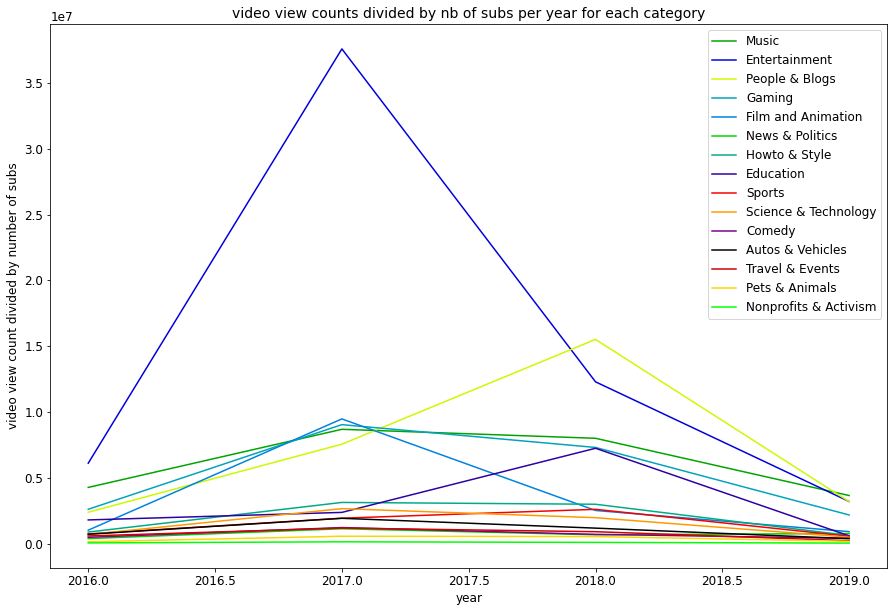

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(views_over_subs_per_year.shape[0]):
    plt.plot(
        views_over_subs_per_year.loc[
            i,
        ][2:],
        label=views_over_subs_per_year.loc[i,][
            0:1
        ][0],
        color=cm(1.*views_over_subs_per_year_groupby[views_over_subs_per_year_groupby.category==views_over_subs_per_year.loc[i,][0:1][0]].index/NUM_COLORS)
    )
    
plt.legend(loc="upper right")
plt.xlabel("year")
plt.ylabel("video view count divided by number of subs")
plt.title("video view counts divided by nb of subs per year for each category")
plt.show()

This graph shows that the correlation between view counts and number of subscribers is not only different across different categories, but also different across time. For Entertainment, it seems that videos had a lot of view counts, but viewers were not subscribing to the channels at the same rate as the view counts increased. We observe a similar pattern for Music, but to a lesser extent. However, towards 2019, it seems that the difference between categories are decreasing, indicating that viewers are more likely to subscribe to channels than just view individual videos on YouTube.

### Section 2: Number of Likes and Dislikes

In [ ]:
video_like_count_by_year_groupby = video_count_by_year.like_count.unstack().reset_index()
video_like_count_by_year_groupby.columns.name = None
video_like_count_by_year = video_like_count_by_year_groupby.sort_values(
    by=2019, ascending=False, ignore_index=True
)

In [ ]:
video_dislike_count_by_year_groupby = video_count_by_year.dislike_count.unstack().reset_index()
video_dislike_count_by_year_groupby.columns.name = None
video_dislike_count_by_year = video_dislike_count_by_year_groupby.sort_values(
    by=2019, ascending=False, ignore_index=True
)

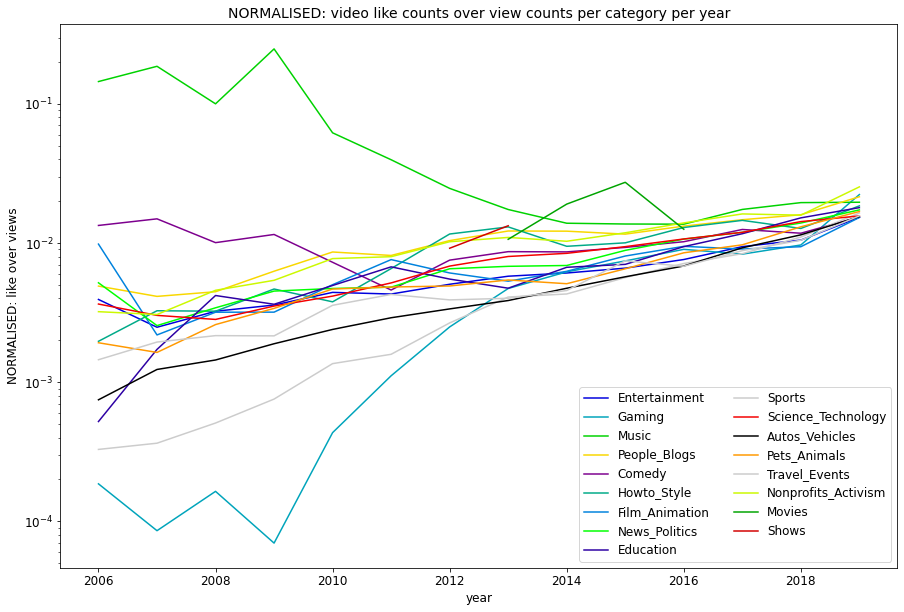

In [ ]:
## 3. like count versus view count - normalise wrt. total like counts over view counts for each category for each year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:]
        / (video_view_count_by_year.loc[i][2:]),
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
        color=cm(1.*video_like_count_by_year_groupby[video_like_count_by_year_groupby.categories==video_like_count_by_year.loc[i,][0:1][0]].index/NUM_COLORS)
    )
plt.semilogy()
plt.legend(loc="lower right", ncol=2)
plt.xlabel("year")
plt.ylabel("NORMALISED: like over views")
plt.title("NORMALISED: video like counts over view counts per category per year")
plt.show()


The graph shows that while Music up until the year 2012 had larger ratio of likes over counts and Gaming had compared to Music a very low ratio, most categories have converged to a similar line from 2012 onwards. The only clear outlier we observe is a spike for Movies between 2013 and 2016. The measures of video likes or dislikes over counts is very interesting, since when the video’s view counts increase so does  the rate of likes and dislikes (Khan & Vong, 2014).

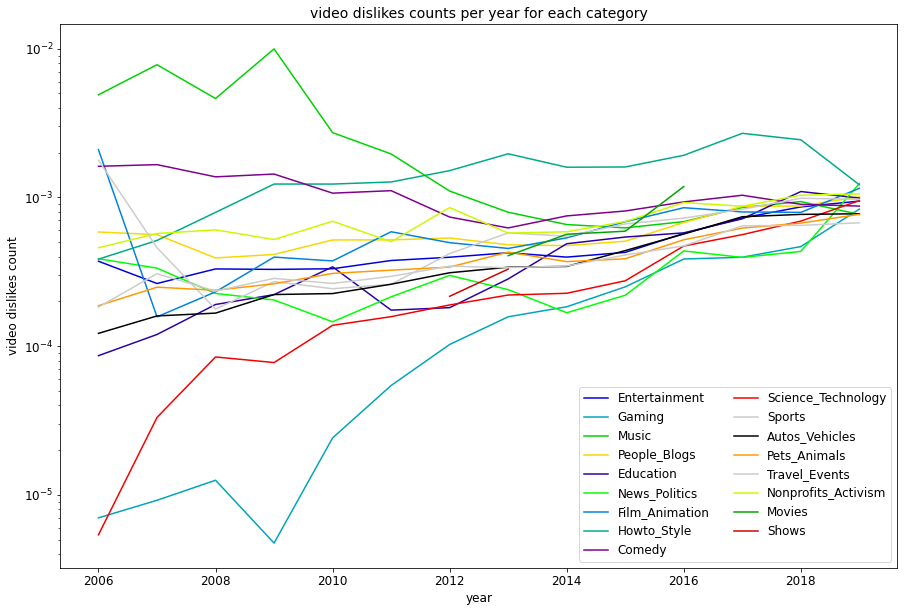

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_dislike_count_by_year.shape[0]):
    plt.plot(
        video_dislike_count_by_year.loc[
            i,
        ][2:]
        / (video_view_count_by_year.loc[i][2:]),
        label=video_dislike_count_by_year.loc[i,][
            0:1
        ][0],
        color=cm(1.*video_dislike_count_by_year_groupby[video_dislike_count_by_year_groupby.categories==video_dislike_count_by_year.loc[i,][0:1][0]].index/NUM_COLORS)
    )
plt.semilogy()  
plt.legend(loc="lower right", ncol=2)
plt.xlabel("year")
plt.ylabel("video dislikes count")
plt.title("video dislikes counts per year for each category")
plt.show()


For dislikes, we observe a more divergent pattern than for likes in our sample. As counts increase, we see videos that have a lot of dislikes for example for the category HowTo & Style whereas Gaming and Science & Technology up until the year 2013 did not receive many dislikes / counts. 

## Question 4: What type of titles attract more attention?
Here, we want to do an initial analysis on the titles by analyzing the positive/negative sentiments and personal pronouns used in them, and how it changes from category to category. For Milestone 3, we want to analyse the changing patterns of titles for the three categories we want to focus on.

### Section 1: Number of Words

In [ ]:
def count_words_simple(x):
    return len(x.split(" "))

In [ ]:
# remove all rows with no category label
titles_metadata.categories.replace("", np.nan, inplace=True)
titles_metadata.dropna(subset=["categories"], inplace=True)

titles_metadata['title'] = titles_metadata['title'].apply(lambda x : x.lower())
titles_metadata['numwords'] = titles_metadata['title'].apply(lambda text : count_words_simple(text.strip()))
titles_metadata.head()

,categories,title,numwords
0,Film & Animation,lego city police lego firetruck cartoons about...,13
1,Film & Animation,lego marvel superheroes lego hulk smash iron-m...,12
2,Film & Animation,lego city police lego fireman cartoons about l...,13
3,Film & Animation,lego harry potter complete lego new movie for ...,12
4,Film & Animation,lego city police 1 hour long video for kids le...,14


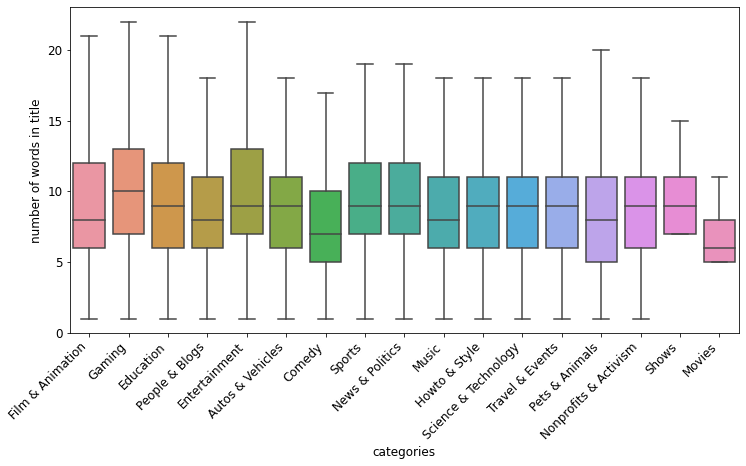

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x="categories", y="numwords", data=titles_metadata, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel("number of words in title")
plt.show()

This graph indicates that the title lengths for videos across different categories are not significantly different from each other. That being said, there are some variations, such as that videos under Comedy seem to have less number of words, whereas videos under Entertainment, Gaming, Sports and News & Politics seems to have more words.

### Section 2: Positive and Negative Sentiments

In this section, we will try to determine whether the titles contain more positive or negative words. We used the dataset from previous Homework 1:
- POSITIVE_URL: `https://ptrckprry.com/course/ssd/data/positive-words.txt`
- NEGATIVE_URL: `https://ptrckprry.com/course/ssd/data/negative-words.txt`

For Milestone 3, we intend to find more complete list of positive and negative words, and also use more advanced models, such as `NLTK` package (https://www.nltk.org/index.html) to analyze the titles and tags with better precision.

In [ ]:
# Import the positive words and negative words database
POSITIVE_URL = 'https://ptrckprry.com/course/ssd/data/positive-words.txt'
NEGATIVE_URL = 'https://ptrckprry.com/course/ssd/data/negative-words.txt'

def get_words(URL):
    r = requests.get(URL)
    data = r.text
    words = []
    for line in data.split('\n'):
        if ';' not in line and len(line) != 0:
            words.append(line)
    return words

positive_words = get_words(POSITIVE_URL)
negative_words = get_words(NEGATIVE_URL)

# compare the words in the headline with the words in the list of pos and neg words otherwise it is too expansive 
def get_columns_pos_neg(list_words, df, colname):
    new_column = []
    for row in df[colname]:
        # get all the words in the headline without ponctuation to be ready to be compared with the neg and pos words  
        row_words = re.sub(r'[^\w\s]', '', row).split(' ')
        if any(word in list_words for word in row_words):
            new_column.append(1)
        else :
            new_column.append(0)      
    return new_column

In [ ]:
# we will first create a copy of titles_metadata with 200000 samples randomly chosen, as running the entire dataset
# would take too much time
titles_metadata_sample = titles_metadata.iloc[
    np.random.choice(np.arange(titles_metadata.shape[0]), 200000), ].reset_index(drop = True)

In [ ]:
# add positive and negative score for each title
titles_metadata_sample['positive'] = get_columns_pos_neg(positive_words, titles_metadata_sample, 'title')
titles_metadata_sample['negative'] = get_columns_pos_neg(negative_words, titles_metadata_sample, 'title')

In [ ]:
# count among those video titles containing positive or negative words from our database,
# how is the share between positive and negative titles
pos_neg_ratio = titles_metadata_sample.groupby("categories").sum()
pos_neg_ratio.drop('numwords', inplace=True, axis=1)
pos_neg_ratio = pos_neg_ratio/(np.column_stack(pos_neg_ratio.positive + pos_neg_ratio.negative).T)

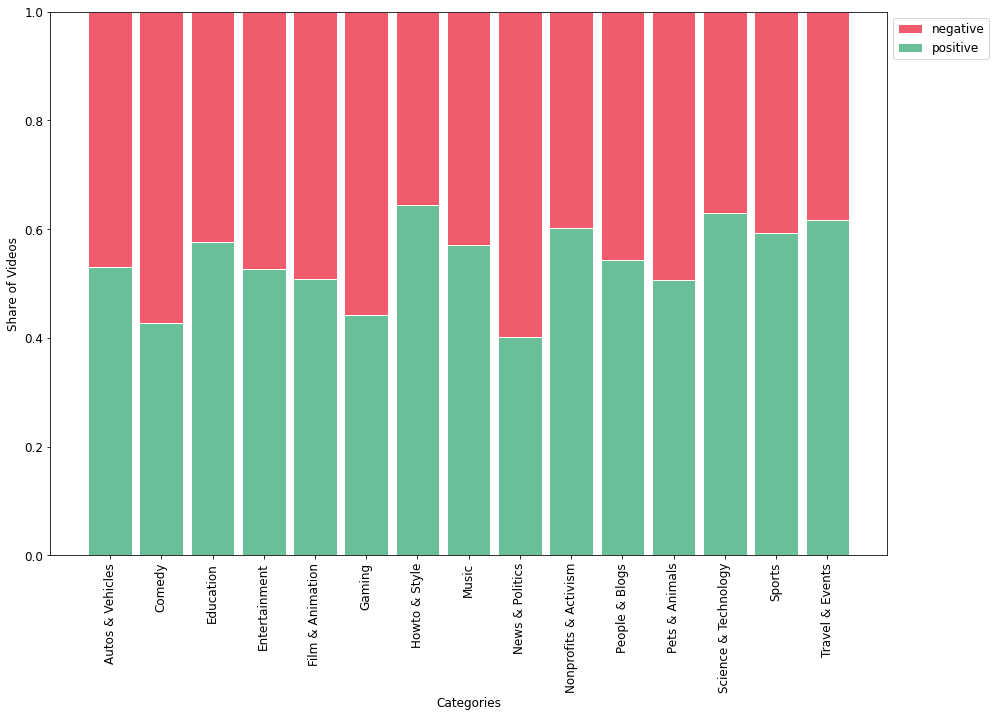

In [ ]:
# plot
barWidth = 0.85
categories = pos_neg_ratio.index.values.tolist()
r = np.arange(len(categories))
# Create red Bars
plt.bar(r, pos_neg_ratio['negative'], bottom=[i for i in pos_neg_ratio['positive']], color='#F15C6C', 
        edgecolor='white', width=barWidth, label = "negative")
# Create green Bars
plt.bar(r, pos_neg_ratio['positive'], color='#69BF97', edgecolor='white', width=barWidth, label = "positive")

# Custom x axis
plt.xticks(r, categories)
plt.xlabel("Categories")
plt.ylabel("Share of Videos")
plt.ylim(0,1)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.xticks(rotation=90)
# Show graphic
plt.show()

Here, we can see that in Comedy, Gaming and News & Politics, there more more negative video titles, Autos & Vehicles, Entertainment and Film & Amination have more or less the same share and the rest of the categories appear to use more positive laguage in their video titles than negative ones.

### Section 3: Personal Pronouns

In [ ]:
# (this section of code is already provided)
feature_wordsets = dict([
    # https://en.wikipedia.org/wiki/English_personal_pronouns
    ('first_person_singular', ['i', 'me', 'my', 'mine', 'myself',
                               "i'd", "i'll", "i'm", "i've", 'id', 'im', 'ive']),
    ('first_person_plural', ['we', 'us', 'our', 'ours', 'ourselves',
                              "we'd", "we'll", "we're", "we've",]),
    ('second_person', ['you','your','yours','yourself',
                              "ya", "you'd", "you'll", "you're", "you've", 'youll', 'youre', 'youve', 
                              'yourselves']),
    ('third_person_singular', ['he','him','his','himself',
                               "he'd", "he's", 'hes',
                               'she','her','hers','herself', 
                               "she'll", "she's", 'shes',
                               'it','its','itself',
                               'themself']),
    ('third_person_plural', ['they','them','their','theirs','themselves',
                              "they'd", "they'll", "they've", 'theyll', 'theyve'])
])

(feature_wordsets.keys())

dict_keys(['first_person_singular', 'first_person_plural', 'second_person', 'third_person_singular', 'third_person_plural'])

In [ ]:
def get_new_columns_pronouns(feature_wordsets, df, colname):
    dict_pronoun_list = dict([
        ('first_person_singular', []),
        ('first_person_plural', []),
        ('second_person', []),
        ('third_person_singular', []),
        ('third_person_plural', []),
    ])
    for headline in df[colname]:
        headline = headline.lower()
        for key in feature_wordsets.keys():
            # if a word corresponding to a pronoun is present in the headline, 
            #then add 1 to this pronoun list (column) otherwise add 0 
            if any(re.search(r'\b' + pronoun + r'\b', headline) for pronoun in feature_wordsets[key]):
                dict_pronoun_list[key].append(1)
            else :
                dict_pronoun_list[key].append(0)
    return dict_pronoun_list

dict_pronoun_list = get_new_columns_pronouns(feature_wordsets, titles_metadata_sample, 'title')

# create the new columns in our dataframe
for col in dict_pronoun_list.keys():
    titles_metadata_sample[col] = dict_pronoun_list[col]

In [ ]:
# count among those video titles containing personal pronouns from our database,
# how is the share between each personal pronoun group
per_pro_ratio = titles_metadata_sample.groupby("categories").sum()
per_pro_ratio.drop(['numwords','positive', 'negative'], inplace=True, axis=1)
per_pro_ratio = per_pro_ratio/(np.column_stack(per_pro_ratio.first_person_singular + 
                                               per_pro_ratio.first_person_plural +
                                               per_pro_ratio.second_person + 
                                               per_pro_ratio.third_person_singular + 
                                               per_pro_ratio.third_person_plural).T)

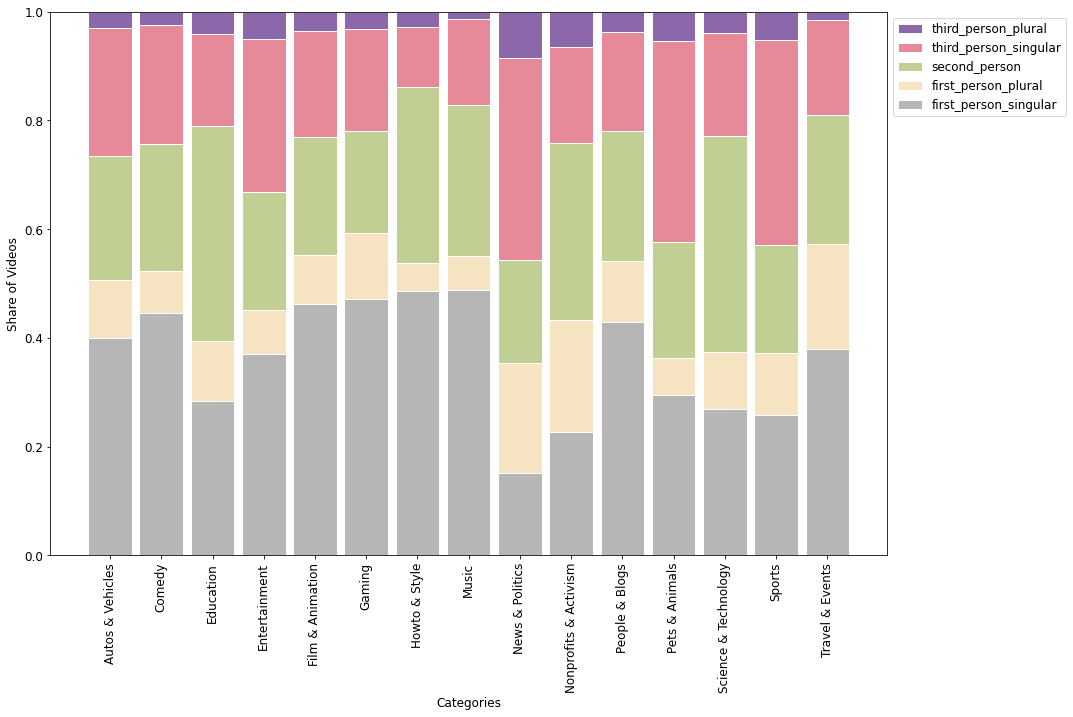

In [ ]:
# plot
barWidth = 0.85
categories = per_pro_ratio.index.values.tolist()
r = np.arange(len(categories))

plt.bar(r, per_pro_ratio['third_person_plural'], 
        bottom=[i+j+k+l for i,j,k,l in zip(per_pro_ratio['first_person_singular'], per_pro_ratio['first_person_plural'], 
                                           per_pro_ratio['second_person'], per_pro_ratio['third_person_singular'])], 
        color='#8C68AB', edgecolor='white', width=barWidth, label = "third_person_plural")

plt.bar(r, per_pro_ratio['third_person_singular'], 
        bottom=[i+j+k for i,j,k in zip(per_pro_ratio['first_person_singular'], 
                                       per_pro_ratio['first_person_plural'], per_pro_ratio['second_person'])], 
        color='#E68A99', edgecolor='white', width=barWidth, label = "third_person_singular")

plt.bar(r, per_pro_ratio['second_person'], 
        bottom=[i+j for i,j in zip(per_pro_ratio['first_person_singular'], per_pro_ratio['first_person_plural'])], 
        color='#C1CF94', edgecolor='white', width=barWidth, label = "second_person")

plt.bar(r, per_pro_ratio['first_person_plural'], 
        bottom=[i for i in per_pro_ratio['first_person_singular']], 
        color='#F5E3C1', edgecolor='white', width=barWidth, label = "first_person_plural")

plt.bar(r, per_pro_ratio['first_person_singular'], 
        color='#B6B6B6', edgecolor='white', width=barWidth, label = "first_person_singular")

# Custom x axis
plt.xticks(r, categories)
plt.xlabel("Categories")
plt.ylabel("Share of Videos")
plt.ylim(0,1)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.xticks(rotation=90)
# Show graphic
plt.show()

This shows that the use of personal pronouns varies significantly between different categories. For example, we would expect News & Politics to use less first personal pronouns and more third personal pronouns, since the subjects are not sold as personal opinions and are more general, whereas for Travel & Events, and People & Blogs, we would expect the video titles to use more first personal pronouns, since the videos are often personal. Both expectations are reflected in the plot.

# *Milestone 3*

# Part 0: Initialising


In [1]:
# Initializing
import matplotlib.font_manager as font_manager

# from matplotlib.lines import Line2D
import matplotlib as mpl

# import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# import os
import re
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf

# import requests
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

NUM_COLORS = 15
cm = plt.get_cmap("nipy_spectral")

mpl.rcParams.update(params)


import warnings

warnings.filterwarnings("ignore")


To start with, we import three datasets that are available from YouNiverse:

``df_timeseries_en.tsv.gz``  
``df_channels_en.tsv.gz``  
``yt_metadata_helper.feather``

We will filter the channels that have been identified as Gaming, as it is our target category. We will do this by identifying the channel IDs with label `Gaming` in `Category` from `df_channels_en.tsv.gz`.


In [2]:
df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])

df_channels = df_channels[df_channels["category_cc"] == "Gaming"]
channel_id_gaming = df_channels.channel


` ` channel_id_gaming `  ` ontains all channel IDs that are identified as Gaming. We will use this list to do initial filtering of both `  `df_time_series `  ` and `  ` video_metadatas ` ` .


In [3]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)

# we filter the channels being labeled as "Gaming" in df_channels_en.tsv.gz
df_time_series = df_time_series[df_time_series["channel"].isin(channel_id_gaming)]


In [4]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
        "display_id",
    ],
)

# we added these two columns for analysis later on.
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday

# we filter the channels being labeled as "Gaming" in df_channels_en.tsv.gz
video_metadatas = video_metadatas[video_metadatas["channel_id"].isin(channel_id_gaming)]


We now have filtered ` ` df_channels `  ` , `  ` df_time_series `  ` and `  ` video_metadatas `  ` . However, they have different numbers of channels. `  ` df_channels `  ` and `  ` video_metadatas `  ` both have 20143 channels, whereas `  ` df_time_series ` ` has 19698 channels. 

When we look closer to the data, we can observe that `df_time_series` only has data from early January 2015 to end September 2019, which could be one reason causing the inconsistency. Therefore, we will then filter videos in ` ` video_metadatas ` ` that are being uploaded from early January 2015 to end September 2019 to keep consistency across three dataframes.


In [5]:
video_metadatas = video_metadatas[
    (video_metadatas["upload_date"] > df_time_series.datetime.min())
    & (video_metadatas["upload_date"] < df_time_series.datetime.max())
]


We now have a list of Gaming channels and the information about their videos. Now, we will proceed to filter out the channels that fit the following conditions:

* The channel has more than 60 % of gaming videos
* The YouTuber uploaded with an average frequency of "every 2 days or less" AND "every 90 days or more"

The reasoning behind these filtering criteria is that we want to have channels that are mainly focusing on gaming, and upload videos not too often but also not too infrequent. Channels with high frequency of upload rate is not likely to be achieved by a single person, and channels that upload too infrequent is likely to be abandoned.

We will achieve this filtering by looking at ` ` video_metadatas ` ` , and calculate:

* The number of videos being labelled as "Gaming" in each channel
* The number of videos being uploaded to each channel
* The time frame within which the YouTuber is active (corresponding to the number of days between the first and last uploads)


In [6]:
# The number of videos being labelled as "Gaming" in each channel
video_metadatas["is_gaming"] = video_metadatas.categories == "Gaming"

# The number of videos being uploaded to each channel
count_per_channel = (
    pd.DataFrame(video_metadatas.groupby("channel_id").count().categories)
    .reset_index()
    .rename(columns={"categories": "nr_videos"})
)
game_video_count_per_channel = pd.DataFrame(
    video_metadatas.groupby("channel_id").sum().is_gaming
).reset_index()

# merge these two datasets
channel_selection = count_per_channel.merge(game_video_count_per_channel)

# The percentage of gaming videos within each channel
channel_selection["pct_gaming"] = (
    channel_selection.is_gaming / channel_selection.nr_videos
)


In [7]:
pct_level = 0.6  # adjust the percentage of videos being labelled as "Gaming" here
selected_channels = list(
    channel_selection[channel_selection["pct_gaming"] >= pct_level].channel_id
)
channel_selection = channel_selection[
    channel_selection["channel_id"].isin(selected_channels)
]


After performing the filtering over percentage of videos being labelled as "Gaming", we have 18230 channels. 

We now want to filter out the channels that upload videos too frequently or too infrequent:


In [8]:
# The time frame within which the YouTuber is active
last_vid_date = (
    pd.DataFrame(video_metadatas.groupby("channel_id").max().upload_date)
    .reset_index()
    .rename(columns={"upload_date": "last_vid_date"})
)
first_vid_date = (
    pd.DataFrame(video_metadatas.groupby("channel_id").min().upload_date)
    .reset_index()
    .rename(columns={"upload_date": "first_vid_date"})
)
total_vids = (
    pd.DataFrame(video_metadatas.groupby("channel_id").count().display_id)
    .reset_index()
    .rename(columns={"display_id": "total_vids"})
)


In [9]:
channel_selection = first_vid_date.merge(last_vid_date)
channel_selection = channel_selection.merge(total_vids)
channel_selection["active_days"] = (
    channel_selection.last_vid_date - channel_selection.first_vid_date
).dt.days
channel_selection["upload_interval"] = (
    channel_selection.active_days / channel_selection.total_vids
)


In [10]:
min_upload_interval = 2  # in days, the channel upload videos on average every x days
max_upload_interval = 90
selected_channels = list(
    channel_selection[
        (channel_selection["upload_interval"] > min_upload_interval)
        & (channel_selection["upload_interval"] < max_upload_interval)
    ].channel_id
)


Here, we filtered out channels that uploaded videos every 2 days or more often, and those who uploaded videos every 90 days or less frequent. Now we have 14730 channels.

Note that `df_time_series` contains less channels than `df_channels` and `video_metadatas` . In order to keep consistency, we will take the channels that can be found across three dataframes.


In [11]:
df_time_series = df_time_series[df_time_series["channel"].isin(selected_channels)]

selected_channels = list(
    df_time_series.groupby("channel").count().reset_index().channel
)


In [12]:
df_channels = df_channels[df_channels["channel"].isin(selected_channels)]

video_metadatas = video_metadatas[video_metadatas["channel_id"].isin(selected_channels)]


After applying the filtering over upload frequency, we now have 14380 channels over all ` `df_time_series `  ` , `  ` df_channels `  ` , and `  `video_metadatas` ` . The filtering is now complete, and we have a list of channels that we are interested in.


We also import two datasets that are created by us, as a complementary to ` ` video_metadatas ` ` :  
* ``title_metadatas``: with three columns (``categories``, ``display_id``, ``title``), containing information about the title names of each video in ``video_metadatas``.
* ``tag_metadatas``: with three columns (``categories``, ``display_id``, ``tags``), containing information about the tags of each video in ``video_metadatas``.

We will filter videos from channels that we selected so far.


In [13]:
title_metadatas = pd.read_feather("./data/yt_metadata_title_helper.feather")

title_metadatas = title_metadatas[
    title_metadatas["display_id"].isin(video_metadatas.display_id)
]


In [14]:
title_metadatas.head()


,categories,display_id,title
1792,Gaming,M0x6TJmMwL4,Blasphemous is Amazing!
1793,Gaming,ofAIp6dad00,I review all 42 Genesis Mini games
1794,Gaming,cXHRNThI27A,Disenchantment Jester Season 2
1795,Gaming,cDSo3mUNEEM,💀 Death Stranding is boring as Hell
1796,Gaming,rJmT1Rq24qE,Happy Friday the 13th. I'm going to try and fi...


In [15]:
tag_metadatas = pd.read_feather("./data/yt_metadata_tags_helper.feather")

tag_metadatas = tag_metadatas[
    tag_metadatas["display_id"].isin(video_metadatas.display_id)
]


In [16]:
tag_metadatas.head()


,categories,display_id,tags
1792,Gaming,M0x6TJmMwL4,"video,games,retrogamer3,ed,findlay,Blasphemous..."
1793,Gaming,ofAIp6dad00,"video,games,retrogamer3,ed,findlay,Sega,Genesi..."
1794,Gaming,cXHRNThI27A,"video,games,retrogamer3,ed,findlay,Disenchantm..."
1795,Gaming,cDSo3mUNEEM,"video,games,retrogamer3,ed,findlay,Death Stran..."
1796,Gaming,rJmT1Rq24qE,"video,games,retrogamer3,ed,findlay,Friday the ..."


# Part 1: Milestone 3 Analysis

Given the results in Milestone 2, we decided to focus on the category of Gaming. The reason behind this choice is because we are trying to help our little brother to succeed, and since he is just a single person without a big team behind him it seems more reasonable than e.g. Movies or Film & Entertainment. Therefore, we decided to eliminate Music, How-to & Style, Education, Science & Technology, Entertainment, Film & Entertainment, People & Blogs, Comedy, Movies and Shows.

## Key Questions:

 - Which factors help a YouTuber in Gaming gain more subscribers?
 - How do sentiments in titles and tags affect views and how do these relationships change over time?


### Sub-Question 1 

**Description:** How does the video upload frequency, time of the week, and video length affect the subscription rate of the channels?
**Method:** Model this using a linear regression model.  
**Timeline:** By 13/12/2022  
**Organization:** Wenxiu  


In [17]:
# calculate which weekday each channel usually upload videos
avg_upload_weekday = (
    pd.DataFrame(video_metadatas.groupby("channel_id").mean().weekNumber)
    .reset_index()
    .rename(columns={"weekNumber": "avg_upload_weekday"})
)

# calculate the average video duration of videos uploaded for each channel
avg_video_duration = (
    pd.DataFrame(video_metadatas.groupby("channel_id").mean().duration)
    .reset_index()
    .rename(columns={"duration": "avg_video_duration"})
)


In [18]:
# merge the two dataframes from above, and merge with
channel_selection = channel_selection.merge(avg_upload_weekday)
channel_selection = channel_selection.merge(avg_video_duration)
channel_selection = channel_selection.merge(
    df_channels.loc[:, ["channel", "subscribers_cc"]].rename(
        columns={"channel": "channel_id"}
    )
)


In [19]:
# select the columns from channel_selection for statistical model
model_data = channel_selection.loc[
    :, ["upload_interval", "avg_video_duration", "subscribers_cc"]
]

# normalise the data
xmean = np.mean(model_data, axis=0)
xstd = np.std(model_data, axis=0)
Xbzs = (model_data - xmean) / xstd

# add weekday information
Xbzs = Xbzs.join(
    pd.get_dummies(
        round(channel_selection.avg_upload_weekday).apply(lambda x: int(x)),
        prefix="day",
    )
)


In [20]:
import statsmodels.formula.api as smf

# Declares the model
mod = smf.ols(
    formula="subscribers_cc ~ \
              upload_interval + avg_video_duration + \
              C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         subscribers_cc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.293
Date:                Fri, 23 Dec 2022   Prob (F-statistic):           1.19e-06
Time:                        16:02:33   Log-Likelihood:                -20383.
No. Observations:               14380   AIC:                         4.078e+04
Df Residuals:                   14371   BIC:                         4.085e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1583      0

The baseline of the model is: A channel with median upload interval, median average video duration and upload videos usually on Mondays.

| | Number of Subscribers|
| :--- | :---: |
| Intercept | -0.1583 (0.698) |
| Tuesday | 0.0872 (0.842) |
| Wednesday | 0.1919 (0.639) |
| Thursday | 0.1545 (0.705) |
| Friday | 0.1534 (0.707) |
| Saturday | 0.2544 (0.545) |
| Sunday | 0.1731 (0.764) |
| Upload interval | -0.0497 (0.000***) |
| Average video duration | -0.0263 (0.002**) |
| $R^2$ | 0.003 |
| Adj. $R^2$ | 0.002 |
| No. obs. | 14380 |

SEs of coefficients are in parentheses. $^{***}P <0.001$, $^{**}P<0.01$, and $^{*}P<0.05$.

The results from the linear model indicate two statistically significant terms (with significance level of 0.005): upload interval and average video duration. The coefficients of these two terms suggest that:

* the higher the upload interval, the lower the subscription rate
* the higher the average video duration, the lower the subscription rate

On the other hand, it seems that time of upload during the week doesn't have a strong influence on the subscription rate of the channels. However, it should be noted that the average upload date of videos is highly concentrated on Thursday for the selected channels (as seen from the table below), and this would be the reason why the time of upload during the week is not as important.

| Weekday | Number of Channels |
| --- | --- |
| Monday | 6 |
| Tuesday | 40 |
| Wednesday | 1332 |
| Thursday | 11394 |
| Friday | 1501 |
| Saturday | 101 |
| Sunday | 6 |


### Sub-Question 2

**Description:** How does the language used in titles affect subscription number?  
**Method:** We will classify the sentiments of titles and tags using packages such as NLTK and try to see if this factor affects subscription number of the channels using relevant skills we learned in observational studies.  
**Timeline:** By 15/12/2022  
**Organization:** Wenxiu  


In [21]:
# NLP libraries
import spacy, nltk, sklearn

# Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialise the Spacy analyzer in English
nlp = spacy.load("en_core_web_sm")


We will then move on to determine the sentiments of titles, and their effect on the view counts.


In [22]:
positive_sent = []
negative_sent = []
neutral_sent = []
compound_sent = []

# iterate through the sentences, get polarity scores, choose a value
analyzer = SentimentIntensityAnalyzer()
for title in title_metadatas.title:
    score = analyzer.polarity_scores(title)
    positive_sent.append(score["pos"])
    negative_sent.append(score["neg"])
    neutral_sent.append(score["neu"])
    compound_sent.append(score["compound"])

video_metadatas["title_pos_scr"] = positive_sent
video_metadatas["title_neg_scr"] = negative_sent
video_metadatas["title_neu_scr"] = neutral_sent
video_metadatas["title_com_scr"] = compound_sent


In [23]:
# assign each title either as positive, negative or neutral
video_metadatas["pos_vid"] = video_metadatas["title_com_scr"] > (1 - 2 / 3)
video_metadatas["neu_vid"] = (video_metadatas["title_com_scr"] < (1 - 2 / 3)) & (
    video_metadatas["title_com_scr"] > -(1 - 2 / 3)
)
video_metadatas["neg_vid"] = video_metadatas["title_com_scr"] < -(1 - 2 / 3)


In [24]:
# select the data for the model
model_data = video_metadatas.loc[:, ["duration", "view_count"]]

# normalise the data
xmean = np.mean(model_data, axis=0)
xstd = np.std(model_data, axis=0)
Xbzs = (model_data - xmean) / xstd

# add weekday information
Xbzs = Xbzs.join(pd.get_dummies(video_metadatas.weekNumber, prefix="day"))
Xbzs = Xbzs.join(video_metadatas.loc[:, ["pos_vid", "neg_vid"]])

# Declares the model
mod = smf.ols(
    formula="view_count ~ C(pos_vid) + C(neg_vid) + duration + \
              C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     82.12
Date:                Fri, 23 Dec 2022   Prob (F-statistic):          2.91e-153
Time:                        16:45:22   Log-Likelihood:            -4.4539e+06
No. Observations:             3139185   AIC:                         8.908e+06
Df Residuals:                 3139175   BIC:                         8.908e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0074      0

The baseline of the model is: A video with median duration, being uploaded on Mondays, and with neutral titles.

The result shows title sentiment, duration and upload time of the week are all statistically significant when determining view counts of the video. More specifically:
* Videos uploaded between Thursday and Saturday are more likely to have higher view counts
* Showing positive or negative sentiments would increase view counts
* Having longer video duration would decrease view counts

However, from graphs below, we can see that the majority of the videos were classified as "neutral". This suggests that the result of the model might be biased. In order to gain a better and fairer idea over the effect of sentiments in titles, we select the videos such that the number of positive, neutral and negative videos are the same.


Text(0.5, 1.0, 'Sentimental Analysis: Distribution')

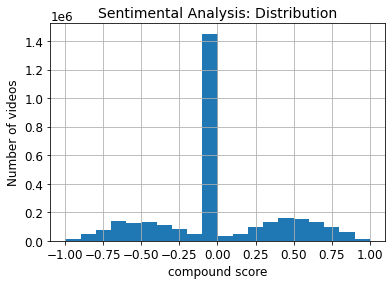

In [25]:
# visualise the result
video_metadatas["title_com_scr"].hist(bins=20)
plt.xlabel("compound score")
plt.ylabel("Number of videos")
plt.title("Sentimental Analysis: Distribution")


The histogram above shows that the majority of the video titles are neutral. Let's now look closer at this by category of videos, since many channels also have videos from categories other than "Gaming".


In [26]:
# get category list
categories_list = np.unique(video_metadatas.categories)
categories_list = categories_list[1:]

# get bin interval
bin_step = np.arange(-1, 1.1, 0.2)

# calculate how many videos of each category fall in the corresponding bin
by_category_data = np.zeros((len(categories_list), len(bin_step) - 1), dtype=int)

for i in np.arange(len(categories_list)):
    by_category_data[i,] = np.histogram(
        video_metadatas[
            video_metadatas["categories"] == categories_list[i]
        ].title_com_scr,
        bins=bin_step,
    )[0]

bin_mid_pt = (bin_step[0:-1] + bin_step[1:]) / 2
bin_mid_pt = [round(item, 2) for item in list(bin_mid_pt)]

# get
data = by_category_data.T / (np.sum(by_category_data, axis=1))


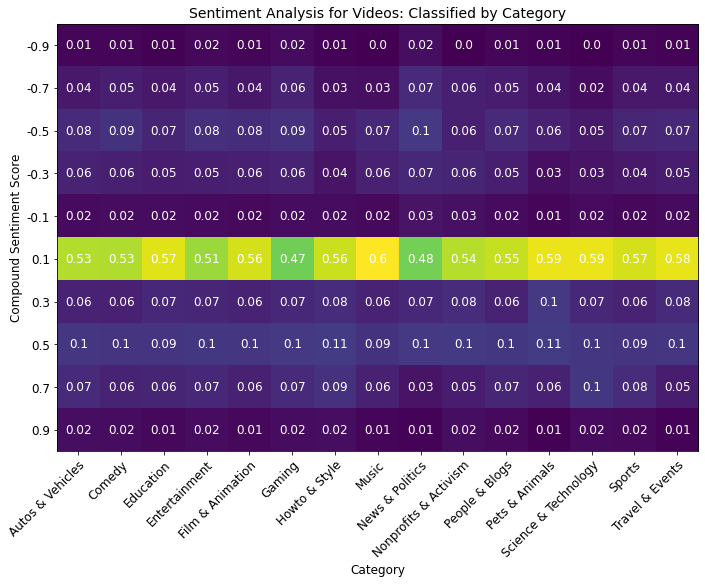

In [27]:
fig, ax = plt.subplots(figsize=(10, 15))
im = ax.imshow(data)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(categories_list)), labels=categories_list)
ax.set_yticks(np.arange(len(bin_mid_pt)), labels=bin_mid_pt)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(bin_mid_pt)):
    for j in range(len(categories_list)):
        text = ax.text(j, i, round(data[i, j], 2), ha="center", va="center", color="w")

ax.set_title("Sentiment Analysis for Videos: Classified by Category")
ax.set_xlabel("Category")
ax.set_ylabel("Compound Sentiment Score")

fig.tight_layout()
plt.show()


The heat map plot above shows similar information as the histogram, but for all categories of videos in our data sample. It seems that "Gaming" videos are already among the categories with lowest share of neutral titles.

Now, we will further filter a data sample for the purpose of this analysis, such that the share between videos with positive, negative and neutral titles is more or less the same.


In [28]:
# we will filter the data such that the number of positiv
filtered_metadatas = video_metadatas
pos_vid_ind = np.where(filtered_metadatas["pos_vid"] == True)[0]
neg_vid_ind = np.where(filtered_metadatas["neg_vid"] == True)[0]
neu_vid_ind = np.where(filtered_metadatas["neu_vid"] == True)[0]

sample_size = min(
    [np.shape(neg_vid_ind), np.shape(neu_vid_ind), np.shape(pos_vid_ind)]
)[0]
selected_index = list(random.choices(pos_vid_ind, k=sample_size))
selected_index += list(random.choices(neg_vid_ind, k=sample_size))
selected_index += list(random.choices(neu_vid_ind, k=sample_size))
filtered_metadatas = filtered_metadatas.iloc[selected_index]


After filtering, the data sample seems more balanced, for both sentiments and days of the week:

| Weekday | Number of Videos |
| --- | --- |
| positive titles | 615479 |
| neutral titles | 615479 |
| negative titles | 615479 |
| Monday | 258922 |
| Tuesday | 265411 |
| Wednesday | 270010 |
| Thursday | 268505 |
| Friday | 277740 |
| Saturday | 259516 |
| Sunday | 246333 |

With this, we will proceed with the modelling:


In [29]:
model_data = filtered_metadatas.loc[
    :,
    [
        "duration",
        "view_count",
        "like_count",
        "dislike_count",
    ],
]
# normalise the data
xmean = np.mean(model_data, axis=0)
xstd = np.std(model_data, axis=0)
Xbzs = (model_data - xmean) / xstd

Xbzs = Xbzs.join(pd.get_dummies(filtered_metadatas["weekNumber"], prefix="day"))
Xbzs = Xbzs.join(filtered_metadatas.loc[:, ["pos_vid", "neg_vid"]])


In [30]:
# Declares the model
mod = smf.ols(
    formula="view_count ~ C(pos_vid) + C(neg_vid) + duration + \
    C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     286.8
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:47:07   Log-Likelihood:            -1.0688e+07
No. Observations:             7034990   AIC:                         2.138e+07
Df Residuals:                 7034980   BIC:                         2.138e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0101      0

In [31]:
# Declares the model
mod = smf.ols(
    formula="like_count ~ C(pos_vid) + C(neg_vid) + duration + \
C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     569.7
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:48:42   Log-Likelihood:            -9.9106e+06
No. Observations:             6987891   AIC:                         1.982e+07
Df Residuals:                 6987881   BIC:                         1.982e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0151      0

In [32]:
# Declares the model
mod = smf.ols(
    formula="dislike_count ~ C(pos_vid) + C(neg_vid) + duration + \
C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:          dislike_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     422.4
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:50:15   Log-Likelihood:            -9.8560e+06
No. Observations:             6987891   AIC:                         1.971e+07
Df Residuals:                 6987881   BIC:                         1.971e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0099      0

The baseline of the model is: A video that is being uploaded on Monday, with neutral titles, and median duration.

|  | View Counts | Like Counts | Dislike Counts |
| :--- | :---: | :---: | :---: |
| Intercept | -0.0204 (0.000***) | -0.0229 (0.000***) | -0.0194 (0.000***) |
| Tuesday | -0.0010 (0.439) | -0.0009 (0.453) | -0.0085 (0.969) |
| Wednesday | 0.0122 (0.000***) | 0.0017 (0.178) | 9.058e-05 (0.953) |
| Thursday |  0.0068 (0.000***) | 0.0013 (0.286) | -0.0030 (0.053) |
| Friday |  0.0101 (0.000***) | 0.0068 (0.000***) | 0.0026 (0.094) |
| Saturday | 0.0260 (0.000***) | 0.0320 (0.000***) | 0.0213 (0.000***) |
| Sunday |  0.0059 (0.000***) | 0.0165 (0.000***) | 0.0150 (0.000***) |
| Positive title | 0.0132 (0.000***) | 0.0140 (0.000***) | 0.0133 (0.000***) |
| Negative title | 0.0157 (0.000***) | 0.0240 (0.000***) | 0.0285 (0.000***) |
| Duration | -0.0178 (0.000***) | -0.0257 (0.000***) | -0.0176 (0.000***) |
| $R^2$ | 0.000 | 0.001 | 0.000 |
| Adj. $R^2$ | 0.000 | 0.001 | 0.000 |
| No. obs. | 7040768 | 6994858 | 6994858 |

SEs of coefficients are in parentheses. $^{***}P <0.001$, $^{**}P<0.01$, and $^{*}P<0.05$.


The result shows title sentiment, duration and upload time of the week are all statistically significant when determining view counts of the video. This alligns with the result from previous model. More specifically:
* Videos uploaded on Wednesdays, Fridays and Saturdays are more likely to have higher view counts  
* Showing positive or negative sentiments would increase view counts compared with neutral sentiments, like counts and dislike counts. Comparing to positive sentiments, showing negative sentiments seems to attract more view counts, more likes and dislikes.
* Having longer video duration would decrease view counts, like counts and dislike counts.


---


### Analyze the effect of the capitalized words in title


Lets implement the sub question 2, the goal is to find a relation btw the number of views and the titles (length, sentiment, casefold, etc...). For that an observational studies would be highly recommended to compare what is comparable. For that we will keep the channel id to see the number of subs of the channel and compare pairwise similar nb of subs.


In [33]:
title_metadatas = pd.read_feather("./data/yt_metadata_title_filtered.feather")


In [34]:
title_metadatas.drop(["index", "categories"], axis=1, inplace=True)


In [35]:
metadatas = pd.merge(video_metadatas, title_metadatas, on="display_id")


In [36]:
metadatas.head(2)


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber,is_gaming,title_pos_scr,title_neg_scr,title_neu_scr,title_com_scr,pos_vid,neu_vid,neg_vid,title
0,Gaming,2019-09-29,892,58.0,3.0,584.0,UCzWm1-4XF7AHxVUTkHCM1uw,M0x6TJmMwL4,2019,6,True,0.672,0.0,0.328,0.6239,True,False,False,Blasphemous is Amazing!
1,Gaming,2019-09-22,2428,60.0,11.0,1023.0,UCzWm1-4XF7AHxVUTkHCM1uw,ofAIp6dad00,2019,6,True,0.000,0.0,1.000,0.0000,False,True,False,I review all 42 Genesis Mini games


Distribution of weekdays upload dates


Text(0, 0.5, 'Number of videos')

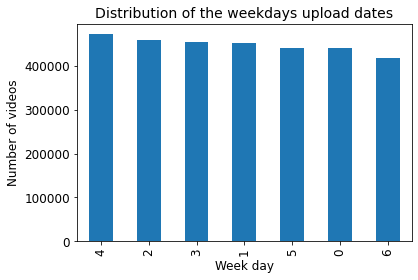

In [37]:
metadatas.weekNumber.value_counts().plot(kind="bar")
plt.title("Distribution of the weekdays upload dates")
plt.xlabel("Week day")
plt.ylabel("Number of videos")


In [38]:
# we need to improve the hw1 method a bit because we want to make sure that titles with a lot of spaces
# don't have too many words and if there is a typo (e.g "Welcome,in my video" should be counted as 4 words and not 3)
def count_words(x: str):
    new_x = x.replace(",", " ")
    # change anything that isn’t an alphanumeric character or whitespace, and replaces it with a space
    new_x = re.sub(r"[^\w\s]", " ", new_x)
    # Change many consecutive spaces into a single space
    new_x = re.sub(" +", " ", new_x)
    # delete begin/end spaces
    new_x = new_x.strip()
    return len(new_x.split(" "))


def get_freq_capital_words(sentence: str):
    new_x = sentence.replace(",", " ")
    # change anything that isn’t an alphanumeric character or whitespace, and replaces it with a space
    new_x = re.sub(r"[^\w\s]", " ", new_x)
    # Change many consecutive spaces into a single space
    new_x = re.sub(" +", " ", new_x)
    # delete begin/end spaces
    new_x = new_x.strip().split(" ")
    nb_capital_words = 0
    for word in new_x:
        if word.isupper():
            nb_capital_words += 1
    return nb_capital_words / len(new_x)


In [39]:
# test the function
print(count_words("Salut     je suis la"))
print(count_words("Salut,je suis la"))
print(count_words("#FuckCancer | I'VE GOT SOME GREAT NEWS!"))
print(count_words("DISNEY CHRISTMAS VLOG! || Zak Longo"))
print(count_words("Sims 4 - SHOOTING SIMS WITH A GUN - The Sims 4"))
print(count_words("###ADA#ada##"))

# test capitalized words function
print(get_freq_capital_words("Sims 4 - SHOOTING SIMS WITH A GUN - The Sims 4"))
print(get_freq_capital_words("###ADA###salut|||test&SALUT"))


4
4
7
5
10
2
0.5
0.5


In [40]:
metadatas["title_nb_words"] = metadatas.title.apply(lambda title: count_words(title))


In [41]:
metadatas["freq_capitalize_words"] = metadatas.title.apply(
    lambda title: get_freq_capital_words(title)
)


In [42]:
metadatas.head()


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber,...,title_pos_scr,title_neg_scr,title_neu_scr,title_com_scr,pos_vid,neu_vid,neg_vid,title,title_nb_words,freq_capitalize_words
0,Gaming,2019-09-29,892,58.0,3.0,584.0,UCzWm1-4XF7AHxVUTkHCM1uw,M0x6TJmMwL4,2019,6,...,0.672,0.00,0.328,0.6239,True,False,False,Blasphemous is Amazing!,3,0.000000
1,Gaming,2019-09-22,2428,60.0,11.0,1023.0,UCzWm1-4XF7AHxVUTkHCM1uw,ofAIp6dad00,2019,6,...,0.000,0.00,1.000,0.0000,False,True,False,I review all 42 Genesis Mini games,7,0.142857
2,Gaming,2019-09-20,18,32.0,0.0,2000.0,UCzWm1-4XF7AHxVUTkHCM1uw,cXHRNThI27A,2019,4,...,0.000,0.00,1.000,0.0000,False,True,False,Disenchantment Jester Season 2,4,0.000000
3,Gaming,2019-09-17,587,311.0,116.0,5102.0,UCzWm1-4XF7AHxVUTkHCM1uw,cDSo3mUNEEM,2019,1,...,0.000,0.73,0.270,-0.8957,False,False,True,💀 Death Stranding is boring as Hell,6,0.000000
4,Gaming,2019-09-13,220,35.0,3.0,300.0,UCzWm1-4XF7AHxVUTkHCM1uw,rJmT1Rq24qE,2019,4,...,0.198,0.00,0.802,0.5719,True,False,False,Happy Friday the 13th. I'm going to try and fi...,17,0.058824


Text(0, 0.5, 'nb of titles')

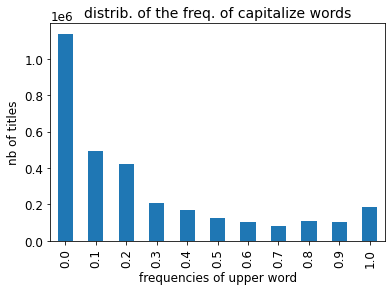

In [43]:
# distrib of the freq capitalized words.
# process for the plot
freq_capit_words = round(metadatas.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalized words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [44]:
freq_capit_words.value_counts().sort_index()

0.0    1137147
0.1     493490
0.2     420310
0.3     209233
0.4     170436
0.5     127063
0.6     105146
0.7      80171
0.8     110418
0.9     101999
1.0     183773
Name: freq_capitalize_words, dtype: int64

In [45]:
# Calculate the log of the view count, ignoring records where the view count is 0
metadatas["view_count_log"] = np.log(
    metadatas.view_count, where=metadatas.view_count != 0
)

# Create a model using the OLS (Ordinary Least Squares) method to predict the view count
# given the nb of words and frequence of capitalized words in title.
mod = smf.ols(
    formula="view_count_log ~ title_nb_words + freq_capitalize_words", data=metadatas
)

# Fit the model to the data
res = mod.fit()

# Print a summary of the model's results
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         view_count_log   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                 1.040e+04
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:51:46   Log-Likelihood:            -7.2584e+06
No. Observations:             3139185   AIC:                         1.452e+07
Df Residuals:                 3139182   BIC:                         1.452e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.21

The frequence of capitalized words in the titles is significant and it increases the number of views on the video. The number of words in the title is significant, however it doesnt seem to have a real impact on the number of views.


In [46]:
# use a threshold (0.3) to differentiate lower to upper titles
# less than 0.3 is considered as lower title.
lower_title_df = metadatas[metadatas["freq_capitalize_words"] < 0.3]
upper_title_df = metadatas[metadatas["freq_capitalize_words"] >= 0.3]

print("# of upper words title", upper_title_df.shape)
print("# of lower words title", lower_title_df.shape)


# of upper words title (1009630, 22)
# of lower words title (2129556, 22)


For more readability, 1st => Take videos with less than 200 000 views


In [47]:
# round the view count to create bins
lower_title_df.view_count = round(lower_title_df.view_count, -4)
lower_title_count = lower_title_df.view_count.value_counts().sort_index().iloc[150:180]
upper_title_df.view_count = round(upper_title_df.view_count, -4)
upper_title_count = upper_title_df.view_count.value_counts().sort_index().iloc[150:180]


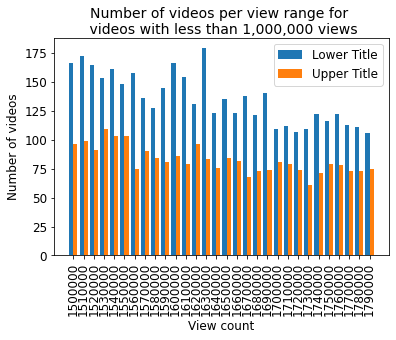

In [48]:
X_axis = np.arange(len(lower_title_count.index))

plt.bar(X_axis - 0.2, lower_title_count.values, 0.4, label="Lower Title")
plt.bar(X_axis + 0.2, upper_title_count.values, 0.4, label="Upper Title")

# plt.xticks(X_axis, lower_title_count.index)
positions = lower_title_count.index
labels = [str(int(pos)) for pos in positions]
plt.xticks(X_axis, labels, rotation="vertical")
plt.title(
    "Number of videos per view range for \n videos with less than 1,000,000 views",
    wrap=True,
)
plt.xlabel("View count")
plt.ylabel("Number of videos")
plt.legend()
plt.show()


### Now match and compare the channels with ~ the same nb of subscribers


In [49]:
# retrieve channels with lower < nb of subs < upper
def get_sample_meta(lower, upper):
    return df_channels[
        (df_channels.subscribers_cc > lower) & (df_channels.subscribers_cc < upper)
    ]


### Impact of capitalized words in title for channels with more than 1 M of subscribers


In [50]:
sample_channels = get_sample_meta(1_000_000, 10_000_000)
sample_channels.shape


(303, 8)

In [51]:
sample_metadatas = metadatas[metadatas.channel_id.isin(sample_channels.channel)]

print(sample_metadatas.shape)
len(sample_metadatas.groupby("channel_id").count())


(94390, 22)


303

Text(0, 0.5, 'nb of titles')

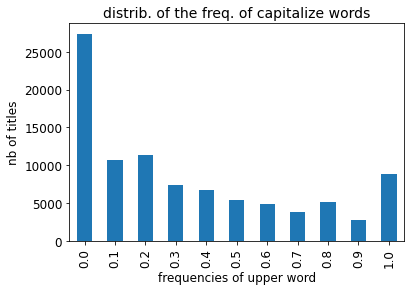

In [52]:
# plot the distrib of the frequ of capitalized words for channels with more than 1M subs
freq_capit_words = round(sample_metadatas.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalized words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [53]:
# check the full upper titles and full lowers ones.
binary_freq_df = sample_metadatas[
    (sample_metadatas.freq_capitalize_words == 0)
    | (sample_metadatas.freq_capitalize_words == 1)
]

full_upper_word_df = binary_freq_df[binary_freq_df["freq_capitalize_words"] == 1]
no_upper_word_df = binary_freq_df[binary_freq_df["freq_capitalize_words"] == 0]

print("# of full upper words title", full_upper_word_df.shape)
print("# of full lower words title", no_upper_word_df.shape)


# of full upper words title (8852, 22)
# of full lower words title (27363, 22)


In [54]:
# create model to predict view count given the nb of words in the title and the frequencies of capitalized words
mod = smf.ols(
    formula="view_count_log ~ title_nb_words + freq_capitalize_words",
    data=sample_metadatas,
)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         view_count_log   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     174.4
Date:                Fri, 23 Dec 2022   Prob (F-statistic):           2.39e-76
Time:                        16:51:59   Log-Likelihood:            -1.8555e+05
No. Observations:               94390   AIC:                         3.711e+05
Df Residuals:                   94387   BIC:                         3.711e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.65

The impact is less important if we filter the channels on the number of subscribers but still it helps to get more views.


In [55]:
# create model to predict view count but for smaller channels now
sample_channels = get_sample_meta(0, 50_000)
sample_metadatas = metadatas[metadatas.channel_id.isin(sample_channels.channel)]
mod = smf.ols(
    formula="view_count_log ~ title_nb_words + freq_capitalize_words",
    data=sample_metadatas,
)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         view_count_log   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     7697.
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:52:02   Log-Likelihood:            -3.7336e+06
No. Observations:             1735396   AIC:                         7.467e+06
Df Residuals:                 1735393   BIC:                         7.467e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.06

The impact of capitalize words is more important for channels with more than 1M of subs compared with channels with less than 50K subs. However it has still a positive impact in the number of views.  


Lets plot the upper and lowers title for big channels (> 100 000 subs) and others.


In [56]:
# split 'big' and 'small' channels
big_channels = df_channels[df_channels.subscribers_cc > 100_000]
little_channels = df_channels[df_channels.subscribers_cc <= 100_000]

print(big_channels.shape)
print(little_channels.shape)


(3586, 8)
(10794, 8)


In [57]:
big_videos_meta = metadatas[metadatas.channel_id.isin(big_channels.channel)]
little_videos_meta = metadatas[metadatas.channel_id.isin(little_channels.channel)]


#### What is the proportion of capitalize title for big ( > 100 000 subs) vs small (< 100 000 subs) channels


Text(0, 0.5, 'nb of titles')

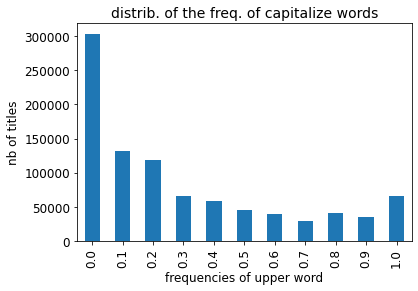

In [58]:
# plot the distrib of the frequ of capitalize words for big channels
freq_capit_words = round(big_videos_meta.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [59]:
# for big channels, calculate the number of titles with more than 0.5 as freq capitalized words (considered as upper titles)
# and divide by the total number of videos
percentage_upper_titles = (
    freq_capit_words.value_counts().sort_index().iloc[-6:].sum()
    / freq_capit_words.value_counts().sum()
    * 100
)

print("Big channels have {:.2f}% of upper titles ".format(percentage_upper_titles))
print(
    "Big channels have {:.2f}% of lower titles ".format(100 - percentage_upper_titles)
)


Big channels have 27.25% of upper titles 
Big channels have 72.75% of lower titles 


Text(0, 0.5, 'nb of titles')

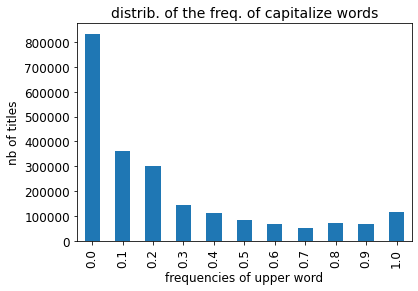

In [60]:
# plot the distrib of the frequ of capitalize words for small channels
freq_capit_words = round(little_videos_meta.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [61]:
# for smaller channels, calculate the number of titles with more than 0.5 as freq capitalized words (considered as upper titles)
# and divide by the total number of videos
percentage_upper_titles = (
    freq_capit_words.value_counts().sort_index().iloc[-6:].sum()
    / freq_capit_words.value_counts().sum()
    * 100
)

print("Small channels have {:.2f}% of upper titles ".format(percentage_upper_titles))
print(
    "Small channels have {:.2f}% of lower titles ".format(100 - percentage_upper_titles)
)


Small channels have 20.60% of upper titles 
Small channels have 79.40% of lower titles 


### Sub-Question 3

**Description:** Can we predict the channel's success based on channel information, including average video length, upload frequency, usual time of uploads, categories of videos uploaded, positive/negative sentiments of the title, person pronouns to address the viewers, the number of words in the title, and the number of tags used?

**Method:** We can implement kNN method or Random Forests to train the dataset.  
**Timeline:** By 13/12/2022  
**Organization:** Dorothee  


In [62]:
video_metadatas["duration_min"] = video_metadatas["duration"] / 60


Add a column to know the day of the week of the upload date for the video


In [63]:
video_metadatas["week_number_mean"] = video_metadatas.groupby("channel_id")[
    "weekNumber"
].transform("mean")

video_metadatas["week_number_mean"] = video_metadatas["week_number_mean"].astype("int")
video_metadatas["mean_duration_min"] = video_metadatas.groupby("channel_id")[
    "duration_min"
].transform("mean")


## Process the dataset and combine them to get all the necessaries informations 


In [64]:
def get_nb_unique_cat(x):
    return x.nunique()


def get_cat(x):
    return list(x.unique())


In [65]:
video_metadatas["nb_diff_cat"] = video_metadatas.groupby("channel_id")[
    "categories"
].transform(get_nb_unique_cat)

cat_per_channels = (
    video_metadatas.groupby("channel_id")["categories"].unique().to_frame()
)


In [66]:
cat_per_channels = cat_per_channels.reset_index()
cat_per_channels = cat_per_channels.rename({"categories": "covered_categories"}, axis=1)
cat_per_channels.head(2)


,channel_id,covered_categories
0,UC--7oyGW0N7fMf164-ZXljQ,"[Gaming, Education, Music, People & Blogs]"
1,UC--b720KocplK9zh0peruqg,"[Gaming, People & Blogs]"


In [67]:
video_metadatas = pd.merge(video_metadatas, cat_per_channels, on="channel_id")


In [68]:
# group by channels and week of upload date to calculate the mean upload frequencies of the channels
grouped = video_metadatas.groupby(
    ["channel_id", pd.Grouper(key="upload_date", freq="W")]
).size()


In [69]:
week_frequency_mean = (
    grouped.groupby(level="channel_id").mean().to_frame().reset_index()
)
week_frequency_mean = week_frequency_mean.rename(columns={0: "week_frequency_mean"})
video_metadatas = pd.merge(video_metadatas, week_frequency_mean, on="channel_id")
week_frequency_mean


,channel_id,week_frequency_mean
0,UC--7oyGW0N7fMf164-ZXljQ,5.911765
1,UC--b720KocplK9zh0peruqg,1.187500
2,UC--vL4ZYLa0bi3TQcuwrhoA,1.533333
3,UC-05oNebNywp5jy7iXZWZzA,2.137097
4,UC-0xJTkutOCoRoBi3YOkHRg,2.511111
...,...,...
14375,UCzyfkcDsgePLd09B-8LxX0g,1.511111
14376,UCzyu0YDMQB_5iSGPOXECcHQ,1.428571
14377,UCzz9_nzdbrxnErTZPZdZ-cw,4.116883
14378,UCzzHicLcWJP2jagxpqebzsA,1.954545


In [70]:
video_metadatas["title_com_scr_mean"] = video_metadatas.groupby("channel_id")[
    "title_com_scr"
].transform("mean")


In [72]:
video_metadatas["title_nb_words_mean"] = metadatas.groupby("channel_id")[
    "title_nb_words"
].transform("mean")


Now find the pronouns in the title


In [74]:
feature_wordsets = dict(
    [
        # https://en.wikipedia.org/wiki/English_personal_pronouns
        (
            "first_person_singular",
            [
                "i",
                "me",
                "my",
                "mine",
                "myself",
                "i'd",
                "i'll",
                "i'm",
                "i've",
                "id",
                "im",
                "ive",
            ],
        ),
        (
            "first_person_plural",
            [
                "we",
                "us",
                "our",
                "ours",
                "ourselves",
                "we'd",
                "we'll",
                "we're",
                "we've",
            ],
        ),
        (
            "second_person",
            [
                "you",
                "your",
                "yours",
                "yourself",
                "ya",
                "you'd",
                "you'll",
                "you're",
                "you've",
                "youll",
                "youre",
                "youve",
                "yourselves",
            ],
        ),
        (
            "third_person_singular",
            [
                "he",
                "him",
                "his",
                "himself",
                "he'd",
                "he's",
                "hes",
                "she",
                "her",
                "hers",
                "herself",
                "she'll",
                "she's",
                "shes",
                "it",
                "its",
                "itself",
                "themself",
            ],
        ),
        (
            "third_person_plural",
            [
                "they",
                "them",
                "their",
                "theirs",
                "themselves",
                "they'd",
                "they'll",
                "they've",
                "theyll",
                "theyve",
            ],
        ),
    ]
)


In [75]:
def get_new_columns_pronouns(feature_wordsets, df, colname):
    dict_pronoun_list = dict(
        [
            ("first_person_singular", []),
            ("first_person_plural", []),
            ("second_person", []),
            ("third_person_singular", []),
            ("third_person_plural", []),
        ]
    )
    for headline in df[colname]:
        headline = headline.lower()
        for key in feature_wordsets.keys():
            # if a word corresponding to a pronoun is present in the headline,
            # then add 1 to this pronoun list (column) otherwise add 0
            if any(
                re.search(r"\b" + pronoun + r"\b", headline)
                for pronoun in feature_wordsets[key]
            ):
                dict_pronoun_list[key].append(1)
            else:
                dict_pronoun_list[key].append(0)
    return dict_pronoun_list


dict_pronoun_list = get_new_columns_pronouns(feature_wordsets, title_metadatas, "title")

# create the new columns in our dataframe
for col in dict_pronoun_list.keys():
    title_metadatas[col] = dict_pronoun_list[col]
title_metadatas.head(3)


,display_id,title,first_person_singular,first_person_plural,second_person,third_person_singular,third_person_plural
0,M0x6TJmMwL4,Blasphemous is Amazing!,0,0,0,0,0
1,ofAIp6dad00,I review all 42 Genesis Mini games,1,0,0,0,0
2,cXHRNThI27A,Disenchantment Jester Season 2,0,0,0,0,0


In [76]:
title_metadatas_without_titles = title_metadatas.drop("title", axis=1)
title_metadatas_without_titles

video_metadatas = pd.merge(
    video_metadatas, title_metadatas_without_titles, on="display_id"
)


In [77]:
df_channels_filtered = df_channels[["channel", "subscriber_rank_sb", "videos_cc"]]

df_channels_filtered = df_channels_filtered.rename({"channel": "channel_id"}, axis=1)
df_channels_filtered.head(2)


,channel_id,subscriber_rank_sb,videos_cc
10,UCEdvpU2pFRCVqU6yIPyTpMQ,18.0,366
42,UCKqH_9mk1waLgBiL2vT5b9g,87.0,1079


In [80]:
full_metadatas = video_metadatas
pd.options.display.max_columns = None
full_metadatas.head()


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber,is_gaming,title_pos_scr,title_neg_scr,title_neu_scr,title_com_scr,pos_vid,neu_vid,neg_vid,duration_min,week_number_mean,mean_duration_min,nb_diff_cat,covered_categories,week_frequency_mean,title_com_scr_mean,title_nb_words_mean,first_person_singular,first_person_plural,second_person,third_person_singular,third_person_plural
0,Gaming,2019-09-29,892,58.0,3.0,584.0,UCzWm1-4XF7AHxVUTkHCM1uw,M0x6TJmMwL4,2019,6,True,0.672,0.00,0.328,0.6239,True,False,False,14.866667,3,32.436631,2,"[Gaming, News & Politics]",1.472441,-0.019817,6.090909,0,0,0,0,0
1,Gaming,2019-09-22,2428,60.0,11.0,1023.0,UCzWm1-4XF7AHxVUTkHCM1uw,ofAIp6dad00,2019,6,True,0.000,0.00,1.000,0.0000,False,True,False,40.466667,3,32.436631,2,"[Gaming, News & Politics]",1.472441,-0.019817,6.090909,1,0,0,0,0
2,Gaming,2019-09-20,18,32.0,0.0,2000.0,UCzWm1-4XF7AHxVUTkHCM1uw,cXHRNThI27A,2019,4,True,0.000,0.00,1.000,0.0000,False,True,False,0.300000,3,32.436631,2,"[Gaming, News & Politics]",1.472441,-0.019817,6.090909,0,0,0,0,0
3,Gaming,2019-09-17,587,311.0,116.0,5102.0,UCzWm1-4XF7AHxVUTkHCM1uw,cDSo3mUNEEM,2019,1,True,0.000,0.73,0.270,-0.8957,False,False,True,9.783333,3,32.436631,2,"[Gaming, News & Politics]",1.472441,-0.019817,6.090909,0,0,0,0,0
4,Gaming,2019-09-13,220,35.0,3.0,300.0,UCzWm1-4XF7AHxVUTkHCM1uw,rJmT1Rq24qE,2019,4,True,0.198,0.00,0.802,0.5719,True,False,False,3.666667,3,32.436631,2,"[Gaming, News & Politics]",1.472441,-0.019817,6.090909,1,0,0,0,0


In [81]:
full_metadatas = pd.merge(df_channels_filtered, full_metadatas, on="channel_id")


In [82]:
full_metadatas.head(2)


,channel_id,subscriber_rank_sb,videos_cc,categories,upload_date,duration,like_count,dislike_count,view_count,display_id,yearNumber,weekNumber,is_gaming,title_pos_scr,title_neg_scr,title_neu_scr,title_com_scr,pos_vid,neu_vid,neg_vid,duration_min,week_number_mean,mean_duration_min,nb_diff_cat,covered_categories,week_frequency_mean,title_com_scr_mean,title_nb_words_mean,first_person_singular,first_person_plural,second_person,third_person_singular,third_person_plural
0,UCEdvpU2pFRCVqU6yIPyTpMQ,18.0,366,Music,2019-09-25,67,19158.0,406.0,356370.0,j8vXlZcWydI,2019,2,False,0.355,0.0,0.645,0.6705,True,False,False,1.116667,2,3.623577,8,"[Music, Entertainment, Howto & Style, Gaming, ...",2.58042,0.105691,8.663957,0,0,0,0,0
1,UCEdvpU2pFRCVqU6yIPyTpMQ,18.0,366,Music,2019-09-24,109,14922.0,354.0,292894.0,IkzyCx9hlFs,2019,1,False,0.000,0.0,1.000,0.0000,False,True,False,1.816667,2,3.623577,8,"[Music, Entertainment, Howto & Style, Gaming, ...",2.58042,0.105691,8.663957,0,0,0,0,0


In [83]:
dataset = full_metadatas.groupby("channel_id").apply(
    lambda group: pd.DataFrame(
        {
            "subscriber_rank_sb": group.subscriber_rank_sb.mean(),
            "videos_cc": group.videos_cc.mean(),
            "week_number_mean": group.week_number_mean.values[0],
            "mean_duration_min": group.mean_duration_min.values[0],
            "nb_diff_cat": group.nb_diff_cat.values[0],
            "covered_categories": group.covered_categories.to_frame().values[0],
            "week_frequency_mean": group.week_frequency_mean.values[0],
            "title_com_scr_mean": group.title_com_scr_mean.values[0],
            "title_nb_words_mean": group.title_nb_words_mean.values[0],
            "first_person_singular_mean": group.first_person_singular.mean(),
            "first_person_plural_mean": group.first_person_plural.mean(),
            "second_person_mean": group.second_person.mean(),
            "third_person_singular_mean": group.third_person_singular.mean(),
            "third_person_plural_mean": group.third_person_plural.mean(),
        }
    )
)


In [85]:
data = pd.get_dummies(video_metadatas["weekNumber"], prefix="day").sum()
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]


Text(0.5, 1.0, 'The Number of Videos Uploaded on each Weekday')

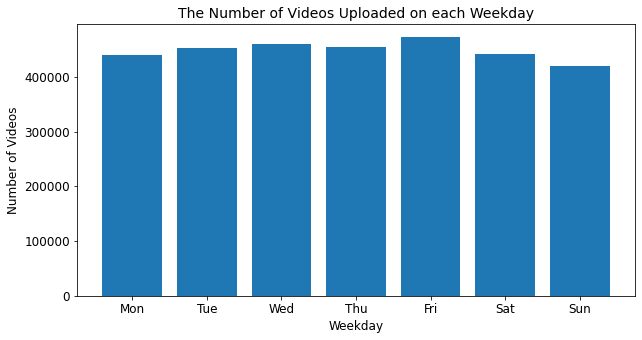

In [86]:
plt.figure(figsize=(10, 5))
plt.bar(day, list(data))
plt.xlabel("Weekday")
plt.ylabel("Number of Videos")
plt.title("The Number of Videos Uploaded on each Weekday")


In average most of the upload date are on Thursday or Wednesday 


<AxesSubplot:>

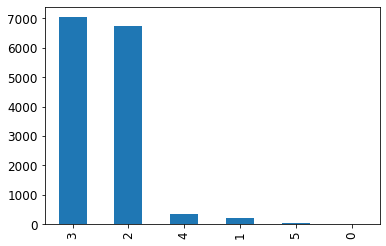

In [87]:
dataset.week_number_mean.value_counts().plot(kind="bar")


### Try to find meaningful features for well ranked channels (rank < 30 000)


In [88]:
dataset.subscriber_rank_sb.median()


364596.0

In [89]:
dataset["well_ranked"] = np.where(dataset.subscriber_rank_sb < 30_000, 1, 0)


In [90]:
dataset.sample()


,,subscriber_rank_sb,videos_cc,week_number_mean,mean_duration_min,nb_diff_cat,covered_categories,week_frequency_mean,title_com_scr_mean,title_nb_words_mean,first_person_singular_mean,first_person_plural_mean,second_person_mean,third_person_singular_mean,third_person_plural_mean,well_ranked
channel_id,,,,,,,,,,,,,,,,
UCutLak8iD_JjUotNmPfInVw,0,540008.0,338.0,3,8.619753,1,[Gaming],1.588235,0.044727,9.422222,0.003704,0.003704,0.003704,0.0,0.0,0


### Using random forest tree with over sampling


In [91]:
# Use over sampling technique
from imblearn.over_sampling import SMOTE

X = dataset.loc[
    :,
    [
        "videos_cc",
        "week_number_mean",
        "nb_diff_cat",
        "title_com_scr_mean",
        "title_nb_words_mean",
        "week_frequency_mean",
        "mean_duration_min",
    ],
]
y = dataset.loc[:, ["well_ranked"]]

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)


In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)


In [93]:
rft = RandomForestClassifier(class_weight="balanced_subsample")
rft.fit(X_train, y_train)
prediction = rft.predict(X_test)
test_acc = metrics.accuracy_score(y_test, prediction)
test_precision = metrics.precision_score(y_test, prediction)
f1_score = metrics.f1_score(y_test, prediction)
print(
    "The test set has an accuracy of {:.3f}, a precision of {:.3f} and a F1 score of {:.3f}.".format(
        test_acc, test_precision, f1_score
    )
)


The test set has an accuracy of 0.902, a precision of 0.882 and a F1 score of 0.905.


### Using k nearest neighbour


In [94]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print("Accuracy : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
print("F1 Score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))


Accuracy : 0.886
Precision : 0.839
F1 Score : 0.894


In [98]:
# divide the dataset into 2 parts, the ones with subs ranking less than the
# median of the subs ranking column and the ones with more than this value
big_channels = dataset[
    dataset.subscriber_rank_sb <= dataset.subscriber_rank_sb.median()
]
small_channels = dataset[
    dataset.subscriber_rank_sb > dataset.subscriber_rank_sb.median()
]

big_channels.mean_duration_min = round(big_channels.mean_duration_min, 0)
small_channels.mean_duration_min = round(small_channels.mean_duration_min, 0)


In [99]:
big_channels.head(2)


,,subscriber_rank_sb,videos_cc,week_number_mean,mean_duration_min,nb_diff_cat,covered_categories,week_frequency_mean,title_com_scr_mean,title_nb_words_mean,first_person_singular_mean,first_person_plural_mean,second_person_mean,third_person_singular_mean,third_person_plural_mean,well_ranked
channel_id,,,,,,,,,,,,,,,,
UC-0xJTkutOCoRoBi3YOkHRg,0,195085.0,111.0,3,6.0,4,"[Gaming, Film & Animation, Music, Entertainment]",2.511111,0.067984,8.884956,0.097345,0.000000,0.088496,0.008850,0.008850,0
UC-10uJUkzxSXa9sEtV67YcA,0,154349.0,562.0,2,25.0,7,"[Gaming, Entertainment, People & Blogs, Travel...",3.760000,0.100178,9.418440,0.092199,0.008865,0.023050,0.008865,0.003546,0


### Sub-Question 4

**Description:** What are the most common topics in each of the chosen category?
**Method:** The yt_metadata_en.jsonl.gz dataset will be used to get a list of tags of each video according to its category. It is further split and classified according to the topics that occur most frequently. This way, we get the most used keywords in each video category and therefore the most popular topics.  
**Timeline:** By 15/12/2022  
**Organization:** Jules  


To start with, we will try to determine the common topics across all videos. This is done by performining topic detection using titles and tags of all selected videos.


In [100]:
import gensim
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import pyLDAvis.gensim_models


In [101]:
# in the topic_detection function, we will perform:
# - initial data cleaning
# - lemmatization
# - stop words removal
# - adding bigrams
# - filter out frequent and rare words
# - bag-of-words representation of the documents


def topic_detection(dataset, datatype):
    if datatype == "title":
        new_list = []
        # replace all underslash to space
        for x in dataset:
            new_text = x.replace("_", " ")
            new_text = new_text.replace("__", " ")
            new_text = new_text.replace("•", " ")
            new_list.append(new_text.lower())

    if datatype == "tag":
        new_list = []
        for x in dataset:
            step1 = x.replace(",", ", ")
            new_list.append(step1.lower())

    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

    processed_docs = list()
    for doc in nlp.pipe(new_list, n_process=5, batch_size=10):

        # Process document using Spacy NLP pipeline.
        ents = doc.ents  # Named entities

        # Keep only words (no numbers, no punctuation).
        # Lemmatize tokens, to lowercase, remove punctuation and remove stopwords.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

        # Remove common words from a stopword list and keep only words of length 2 or more.
        doc = [token for token in doc if token not in STOPWORDS and len(token) > 1]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])

        processed_docs.append(doc)

    docs = processed_docs
    del processed_docs

    # Add bigrams to docs (only ones that appear 15 times or more).
    bigram = Phrases(docs, min_count=15)

    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if "_" in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)

    # Create a dictionary representation of the documents, and filter out frequent and rare words.
    dictionary = Dictionary(docs)

    # Remove rare and common tokens.
    # Filter out words that occur too frequently or too rarely.
    max_freq = 0.5
    min_wordcount = 5
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return corpus, dictionary


In [102]:
corpus_title, dictionary_title = topic_detection(title_metadatas.title, "title")


In [103]:
# models
seed = 42
params = {"passes": 10, "random_state": seed}
base_models = dict()

model_title = LdaMulticore(
    corpus=corpus_title,
    num_topics=8,
    id2word=dictionary_title,
    workers=None,
    passes=params["passes"],
    random_state=params["random_state"],
)


In [104]:
pyLDAvis.enable_notebook(local=True)
data = pyLDAvis.gensim_models.prepare(model_title, corpus_title, dictionary_title)
pyLDAvis.display(data, template_type="notebook")


In [105]:
pyLDAvis.save_html(data, 'title.html')


In [106]:
corpus_tag, dictionary_tag = topic_detection(tag_metadatas.tags, "tag")


In [107]:
# models
seed = 42
params = {"passes": 10, "random_state": seed}
base_models = dict()

model_tag = LdaMulticore(
    corpus=corpus_tag,
    num_topics=8,
    id2word=dictionary_tag,
    workers=None,
    passes=params["passes"],
    random_state=params["random_state"],
)


In [ ]:
pyLDAvis.enable_notebook(local=True)
data = pyLDAvis.gensim_models.prepare(model_tag, corpus_tag, dictionary_tag)
pyLDAvis.display(data, template_type="notebook")


In [ ]:
pyLDAvis.save_html(data, 'tags.html')


### Sub-Question 5

**Description:** Does a channel's success increase with a greater variety of categories?  
**Method:** For this question, we will determine whether the filtered channels use multiple categories in their videos, and if they showed clear shifts from one category to another. Ultimately, we want to use this information and methods such as A/B testing and observational studies to determine whether a greater variety of categories can aid to a channels’ success.  
**Timeline:** By 18/12/2022  
**Organization:** Paul  


In [ ]:
video_metadatas.categories.value_counts().iloc[1:].plot(kind="bar")
plt.title("Number of videos per categories \n (except Gaming topic) for Gaming channels")
plt.xlabel("Category")
plt.ylabel("Number of videos")


Find channels with unique topic


In [ ]:
# get the unique values in the categories for each channel
# (i.e., the categories of videos they have already uploaded once)
gaming_channels_with_categories = video_metadatas.groupby("channel_id").apply(
    lambda group: group.categories.unique()
)

# split the dataset in 2 and the one with only 1 category value mean they uploaded only gaming
# videos and the ones with more than 1 video means they have diverse content
unique_topic_gaming = gaming_channels_with_categories.loc[
    gaming_channels_with_categories.str.len() == 1
]
non_unique_topic_gaming = gaming_channels_with_categories.loc[
    gaming_channels_with_categories.str.len() > 1
]
print("nb of channels with unique topic Gaming : ", unique_topic_gaming.shape)
print("nb of channels without unique topic Gaming : ", non_unique_topic_gaming.shape)


In [ ]:
unique_topic_gaming_channels_descript = df_channels[
    df_channels.channel.isin(unique_topic_gaming.index.values)
]
non_unique_topic_gaming_channels_descript = df_channels[
    df_channels.channel.isin(non_unique_topic_gaming.index.values)
]


In [ ]:
describe_unique = unique_topic_gaming_channels_descript.subscribers_cc.describe()
plt.boxplot(describe_unique, showfliers=False)
plt.show()


In [ ]:
describe_non_unique = non_unique_topic_gaming_channels_descript.subscribers_cc.describe()
plt.boxplot(describe_non_unique, showfliers=False)
plt.show()


### Now we have the dataset to check the differences between unique and non unique categories channels


Try a bootstrap approach


In [ ]:
def get_confidence_interval(data):
    rng = np.random.default_rng()
    return bootstrap(
        (data,),
        np.mean,
        confidence_level=0.95,
        random_state=rng,
    ).confidence_interval


In [ ]:
conf1 = get_confidence_interval(unique_topic_gaming_channels_descript.subscribers_cc)
print(
    "95% confidence interval of number of subs for unique Gaming channels [{:_}, {:_}]".format(
        int(conf1[0]), int(conf1[1])
    )
)
conf2 = get_confidence_interval(
    non_unique_topic_gaming_channels_descript.subscribers_cc
)
print(
    "95% confidence interval of number of subs for non unique Gaming channels [{:_}, {:_}]".format(
        int(conf2[0]), int(conf2[1])
    )
)


From these statistics, we can notice that diverse channels have no more subs in general. 


In [ ]:
# create binary column
unique_topic_gaming_channels_descript["only_gaming"] = 1
print(unique_topic_gaming_channels_descript.shape)
non_unique_topic_gaming_channels_descript["only_gaming"] = 0
print(non_unique_topic_gaming_channels_descript.shape)


In [ ]:
unique_and_non_unique = unique_topic_gaming_channels_descript.append(
    non_unique_topic_gaming_channels_descript
)
unique_and_non_unique.head(2)


In [ ]:
# apply the log to the number of subscribers (because can become too big)
unique_and_non_unique["subscribers_cc_log"] = np.log(
    unique_and_non_unique.subscribers_cc,
    where=unique_and_non_unique.subscribers_cc != 0,
)

# model to predict the number of subscribers given if we have a diversed channel or no.
mod = smf.ols(
    formula="subscribers_cc_log ~ only_gaming",
    data=unique_and_non_unique,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


Channel with only gaming have more subscribers than ones with diverse categories and the coefficient is meaningful
